# *Forecasting of time series*

__Introduction__

In this notebook, we aim to forecast the time series we have using different methods.
We will first forecast each time serie based on its own data. Then using the clustering we obtained with the clustering algorithms, we will forecast the time series by groups defined by their type.
Finally, we will use the very big set of time series from darts (approximately 48'000 time series), to fit our forecasting algorithms and to predict the behavior of the time series. Naturally, we will also do a grid search to choose for the best hyperparameters of each model.
Ultimately, the goal will be to predict the compare the different forecasting methods and to choose the best one.

IMPORTING LIBRARIES

Before we get started, let's import all necessary libraries for performing our time series classification:

In [421]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")


import optuna
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from itertools import chain


from darts import TimeSeries
from darts.utils import statistics
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import *
from darts.datasets import AirPassengersDataset
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

Let us now import the files we will need to forecast our time series.

In [422]:
infile_dfindices = open('data_indices/dfindices_timeseries','rb')
dfindices = pickle.load(infile_dfindices)
infile_dfindices.close()

In [423]:
infile_dfcluster = open('data_indices/df_tm_tocluster','rb')
dfcluster = pickle.load(infile_dfcluster)
infile_dfcluster.close()

In [424]:
infile_df_interpolation = open('data_indices/df_interpolation_ratio','rb')
df_interpolation = pickle.load(infile_df_interpolation)
infile_df_interpolation.close()

In [425]:
def simple_exp_smooth(d,alpha=0.4):  
    mylist= d  # Transform the input into a numpy array 
    cols = len(mylist)  # Historical period length  

    f = list(np.full(cols,np.nan))  # Forecast array  
    f[0] = mylist[0]  # initialization of first forecast  
      # Create all the t+1 forecasts until end of historical period  
    for t in range(1,cols):  
        f[t] = alpha*mylist[t-1]+(1-alpha)*f[t-1]  
    return f

<div class="alert-info">
1. Filtering the dataframe by interpolation ratio
</div>

As done before, we aim to forecast and consider only the time series that are meaningful, which means the time series that have a low interpolation ratio. This is done to avoid useless noise in our analyses and forecasting. For this reason, we keep only the time series with less than 50% of interpolation ratio.

In [426]:
dfcluster

concept1                   concept2            index  \
0     Authentication protocole   Authentication protocole  index_cit_t1_t2   
1     Authentication protocole                 Biometrics  index_cit_t1_t2   
2     Authentication protocole                 Blockchain  index_cit_t1_t2   
3     Authentication protocole  Digital rights management  index_cit_t1_t2   
4     Authentication protocole          Digital signature  index_cit_t1_t2   
...                        ...                        ...              ...   
3120      Zero-knowlegde proof    Symmetric-key algorithm    index_keyword   
3121      Zero-knowlegde proof     Threshold cryptosystem    index_keyword   
3122      Zero-knowlegde proof          Trusted Computing    index_keyword   
3123      Zero-knowlegde proof         Tunneling protocol    index_keyword   
3124      Zero-knowlegde proof       Zero-knowlegde proof    index_keyword   

      cluster  
0         0.0  
1         5.0  
2         5.0  
3         5.0  
4         5.0  
...       ...  
3120      2.0  
3121      NaN  
3122      4.0  
3123      NaN  
3124      1.0  

[3125 rows x 4 columns]

In [427]:
dfindices

concept1                  concept2      date  \
0    Authentication protocole  Authentication protocole    1-01-2   
0    Authentication protocole  Authentication protocole    2-01-2   
0    Authentication protocole  Authentication protocole    3-01-2   
0    Authentication protocole  Authentication protocole    4-01-2   
0    Authentication protocole  Authentication protocole    5-01-2   
..                        ...                       ...       ...   
624      Zero-knowlegde proof      Zero-knowlegde proof   8-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof   9-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  10-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  11-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  12-01-22   

    index_cit_t1_t2 index_cit_t2_t1 index_colab_increm index_colab_notincrem  \
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0          0.836174        0.836174          13.808524              13.77767   
0               0.0             0.0           6.284266              6.284266   
..              ...             ...                ...                   ...   
624             0.0             0.0          54.317264              28.72956   
624             0.0             0.0          19.811067             19.811067   
624        6.706388        6.706388          48.748713             44.762499   
624             0.0             0.0          24.238745             16.901309   
624             0.0             0.0          85.479787             32.221229   

    index_keyword  
0        1.720479  
0        1.720479  
0        1.720479  
0         7.22864  
0        3.355919  
..            ...  
624      8.031585  
624      8.877465  
624     14.777641  
624      6.616964  
624     10.601732  

[157500 rows x 8 columns]

In [428]:
df_interpolation

concept1                 concept2  interpolation_ratio
548   Threshold cryptosystem       Tunneling protocol             0.944444
596       Tunneling protocol   Threshold cryptosystem             0.944444
577       Tunneling protocol               Blockchain             0.928571
73                Blockchain       Tunneling protocol             0.928571
589       Tunneling protocol          Link encryption             0.924603
..                       ...                      ...                  ...
110        Digital signature            Hash function             0.007937
410  Public-key cryptography            Hash function             0.000000
416  Public-key cryptography  Public-key cryptography             0.000000
266            Hash function  Public-key cryptography             0.000000
260            Hash function            Hash function             0.000000

[625 rows x 3 columns]

In [429]:
df_interpolation.loc[df_interpolation['interpolation_ratio']>=0.5]

concept1                  concept2  interpolation_ratio
548    Threshold cryptosystem        Tunneling protocol             0.944444
596        Tunneling protocol    Threshold cryptosystem             0.944444
577        Tunneling protocol                Blockchain             0.928571
73                 Blockchain        Tunneling protocol             0.928571
589        Tunneling protocol           Link encryption             0.924603
..                        ...                       ...                  ...
227  Hardware security module                Blockchain             0.531746
69                 Blockchain  Random number generation             0.503968
477  Random number generation                Blockchain             0.503968
602      Zero-knowlegde proof                Blockchain             0.500000
74                 Blockchain      Zero-knowlegde proof             0.500000

[155 rows x 3 columns]

In [430]:
list_concepts= ['Authentication protocole','Biometrics','Blockchain','Digital rights management'
,'Digital signature','Distributed algorithm','Electronic voting','Functional encryption',
'Hardware acceleration','Hardware security module','Hash function','Homomorphic encryption','Identity management',
'Key management','Link encryption','Post-quantum cryptography','Public-key cryptography','Quantum key distribution',
'Quantum cryptography','Random number generation','Symmetric-key algorithm','Threshold cryptosystem',
'Trusted Computing','Tunneling protocol','Zero-knowlegde proof']

In [431]:
list_indices=['index_cit_t1_t2','index_cit_t2_t1','index_colab_increm','index_colab_notincrem','index_keyword']

In [432]:
list_interpolationratio=[]

numbertm_highextrapolation = 0

for concept1 in list_concepts:
    dfinter1=df_interpolation.loc[df_interpolation['concept1']==concept1]
    for concept2 in list_concepts:
        dfinter2=dfinter1.loc[dfinter1['concept2']==concept2]
        interpolation_score = dfinter2.interpolation_ratio.tolist()[0]
        list_interpolationratio=list_interpolationratio+252*[interpolation_score]
        if interpolation_score>=0.5:
            numbertm_highextrapolation=numbertm_highextrapolation+1

In [433]:
print('There are '+str(numbertm_highextrapolation)+' pairs of technologies with a high interpolation rate')

There are 155 pairs of technologies with a high interpolation rate


In [434]:
dfindices['interpolation_score']=list_interpolationratio

In [435]:
dfindices=dfindices.drop(dfindices[dfindices['interpolation_score'] >=0.5].index)

In [436]:
dfindices

concept1                  concept2      date  \
0    Authentication protocole  Authentication protocole    1-01-2   
0    Authentication protocole  Authentication protocole    2-01-2   
0    Authentication protocole  Authentication protocole    3-01-2   
0    Authentication protocole  Authentication protocole    4-01-2   
0    Authentication protocole  Authentication protocole    5-01-2   
..                        ...                       ...       ...   
624      Zero-knowlegde proof      Zero-knowlegde proof   8-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof   9-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  10-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  11-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  12-01-22   

    index_cit_t1_t2 index_cit_t2_t1 index_colab_increm index_colab_notincrem  \
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0          0.836174        0.836174          13.808524              13.77767   
0               0.0             0.0           6.284266              6.284266   
..              ...             ...                ...                   ...   
624             0.0             0.0          54.317264              28.72956   
624             0.0             0.0          19.811067             19.811067   
624        6.706388        6.706388          48.748713             44.762499   
624             0.0             0.0          24.238745             16.901309   
624             0.0             0.0          85.479787             32.221229   

    index_keyword  interpolation_score  
0        1.720479             0.019841  
0        1.720479             0.019841  
0        1.720479             0.019841  
0         7.22864             0.019841  
0        3.355919             0.019841  
..            ...                  ...  
624      8.031585             0.095238  
624      8.877465             0.095238  
624     14.777641             0.095238  
624      6.616964             0.095238  
624     10.601732             0.095238  

[118440 rows x 9 columns]

<div class="alert-info">
2. Transforming the datatype of date to obtain darts time series
</div>

We now must transform the datatype of the column 'date' to get it acceptable for darts time series.

In [437]:
dfindices['time'] = pd.Series(['12:00' for x in range(len(dfindices))])

In [438]:
combined = dfindices.date.str.cat(dfindices.time,sep=' ')

In [439]:
dfindices['date_and_time']=pd.to_datetime(combined)

In [440]:
dfindices

concept1                  concept2      date  \
0    Authentication protocole  Authentication protocole    1-01-2   
0    Authentication protocole  Authentication protocole    2-01-2   
0    Authentication protocole  Authentication protocole    3-01-2   
0    Authentication protocole  Authentication protocole    4-01-2   
0    Authentication protocole  Authentication protocole    5-01-2   
..                        ...                       ...       ...   
624      Zero-knowlegde proof      Zero-knowlegde proof   8-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof   9-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  10-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  11-01-22   
624      Zero-knowlegde proof      Zero-knowlegde proof  12-01-22   

    index_cit_t1_t2 index_cit_t2_t1 index_colab_increm index_colab_notincrem  \
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0          0.836174        0.836174          13.808524              13.77767   
0               0.0             0.0           6.284266              6.284266   
..              ...             ...                ...                   ...   
624             0.0             0.0          54.317264              28.72956   
624             0.0             0.0          19.811067             19.811067   
624        6.706388        6.706388          48.748713             44.762499   
624             0.0             0.0          24.238745             16.901309   
624             0.0             0.0          85.479787             32.221229   

    index_keyword  interpolation_score   time       date_and_time  
0        1.720479             0.019841  12:00 2002-01-01 12:00:00  
0        1.720479             0.019841  12:00 2002-02-01 12:00:00  
0        1.720479             0.019841  12:00 2002-03-01 12:00:00  
0         7.22864             0.019841  12:00 2002-04-01 12:00:00  
0        3.355919             0.019841  12:00 2002-05-01 12:00:00  
..            ...                  ...    ...                 ...  
624      8.031585             0.095238  12:00 2022-08-01 12:00:00  
624      8.877465             0.095238  12:00 2022-09-01 12:00:00  
624     14.777641             0.095238  12:00 2022-10-01 12:00:00  
624      6.616964             0.095238  12:00 2022-11-01 12:00:00  
624     10.601732             0.095238  12:00 2022-12-01 12:00:00  

[118440 rows x 11 columns]

In [441]:
dfindices = dfindices.drop(['date','time'], axis=1).sort_index(axis=1)

In [442]:
dfindices

concept1                  concept2       date_and_time  \
0    Authentication protocole  Authentication protocole 2002-01-01 12:00:00   
0    Authentication protocole  Authentication protocole 2002-02-01 12:00:00   
0    Authentication protocole  Authentication protocole 2002-03-01 12:00:00   
0    Authentication protocole  Authentication protocole 2002-04-01 12:00:00   
0    Authentication protocole  Authentication protocole 2002-05-01 12:00:00   
..                        ...                       ...                 ...   
624      Zero-knowlegde proof      Zero-knowlegde proof 2022-08-01 12:00:00   
624      Zero-knowlegde proof      Zero-knowlegde proof 2022-09-01 12:00:00   
624      Zero-knowlegde proof      Zero-knowlegde proof 2022-10-01 12:00:00   
624      Zero-knowlegde proof      Zero-knowlegde proof 2022-11-01 12:00:00   
624      Zero-knowlegde proof      Zero-knowlegde proof 2022-12-01 12:00:00   

    index_cit_t1_t2 index_cit_t2_t1 index_colab_increm index_colab_notincrem  \
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0               0.0             0.0           2.699103              2.699103   
0          0.836174        0.836174          13.808524              13.77767   
0               0.0             0.0           6.284266              6.284266   
..              ...             ...                ...                   ...   
624             0.0             0.0          54.317264              28.72956   
624             0.0             0.0          19.811067             19.811067   
624        6.706388        6.706388          48.748713             44.762499   
624             0.0             0.0          24.238745             16.901309   
624             0.0             0.0          85.479787             32.221229   

    index_keyword  interpolation_score  
0        1.720479             0.019841  
0        1.720479             0.019841  
0        1.720479             0.019841  
0         7.22864             0.019841  
0        3.355919             0.019841  
..            ...                  ...  
624      8.031585             0.095238  
624      8.877465             0.095238  
624     14.777641             0.095238  
624      6.616964             0.095238  
624     10.601732             0.095238  

[118440 rows x 9 columns]

In [443]:
dfindices.dtypes

concept1                         object
concept2                         object
date_and_time            datetime64[ns]
index_cit_t1_t2                  object
index_cit_t2_t1                  object
index_colab_increm               object
index_colab_notincrem            object
index_keyword                    object
interpolation_score             float64
dtype: object

<div class="alert-info">
3. Creation of a dataframe of darts time series
</div>

In [444]:
listconcept1=[]
listconcept2=[]
listindextype=[]
listdartstm=[]

for concept1 in tqdm(list_concepts):
    dfconcept1 = dfindices.loc[dfindices['concept1']==concept1]
    for concept2 in list_concepts:
        dfconcept2 = dfconcept1.loc[dfconcept1['concept2']==concept2].copy()
        subdf=dfconcept2.set_index('date_and_time')
        if len(subdf)!=0:
            for index in list_indices:
                dftotimeseries=subdf[index]
                firstimeseries = TimeSeries.from_series(dftotimeseries,freq='MS')
                mytimeseries=statistics.remove_seasonality(firstimeseries,freq=12,model=ModelMode.ADDITIVE,method='STL')
                #print(mytimeseries)
                myvalues = list(TimeSeries.pd_series(mytimeseries))                
                
                smoothed_tm = simple_exp_smooth(myvalues,alpha=0.1)
                mytm = pd.Series(smoothed_tm)
                mytm.index = TimeSeries.pd_series(mytimeseries).index
                
                darts_tm = TimeSeries.from_series(mytm)
                
                #print(darts_tm)
                listconcept1.append(concept1)
                listconcept2.append(concept2)
                listindextype.append(index)
                listdartstm.append(darts_tm)

  0%|          | 0/25 [00:00<?, ?it/s]

In [445]:
dftm = pd.DataFrame({'concept1':listconcept1,'concept2':listconcept2,'indextype':listindextype,'Time serie':listdartstm})

In [446]:
dftm

concept1                  concept2  \
0     Authentication protocole  Authentication protocole   
1     Authentication protocole  Authentication protocole   
2     Authentication protocole  Authentication protocole   
3     Authentication protocole  Authentication protocole   
4     Authentication protocole  Authentication protocole   
...                        ...                       ...   
2345      Zero-knowlegde proof      Zero-knowlegde proof   
2346      Zero-knowlegde proof      Zero-knowlegde proof   
2347      Zero-knowlegde proof      Zero-knowlegde proof   
2348      Zero-knowlegde proof      Zero-knowlegde proof   
2349      Zero-knowlegde proof      Zero-knowlegde proof   

                  indextype                                         Time serie  
0           index_cit_t1_t2  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
1           index_cit_t2_t1  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
2        index_colab_increm  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
3     index_colab_notincrem  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
4             index_keyword  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
...                     ...                                                ...  
2345        index_cit_t1_t2  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
2346        index_cit_t2_t1  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
2347     index_colab_increm  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
2348  index_colab_notincrem  (((<TimeSeries (DataArray) (date_and_time: 1, ...  
2349          index_keyword  (((<TimeSeries (DataArray) (date_and_time: 1, ...  

[2350 rows x 4 columns]

In [447]:
mylistcluster = dfcluster.cluster.tolist()
len(mylistcluster)

3125

In [448]:
myclusters = [1+int(x) for x in mylistcluster if str(x)!='nan']
len(myclusters)

2350

In [449]:
dftm['cluster']=myclusters

In [450]:
dftm

concept1                  concept2  \
0     Authentication protocole  Authentication protocole   
1     Authentication protocole  Authentication protocole   
2     Authentication protocole  Authentication protocole   
3     Authentication protocole  Authentication protocole   
4     Authentication protocole  Authentication protocole   
...                        ...                       ...   
2345      Zero-knowlegde proof      Zero-knowlegde proof   
2346      Zero-knowlegde proof      Zero-knowlegde proof   
2347      Zero-knowlegde proof      Zero-knowlegde proof   
2348      Zero-knowlegde proof      Zero-knowlegde proof   
2349      Zero-knowlegde proof      Zero-knowlegde proof   

                  indextype  \
0           index_cit_t1_t2   
1           index_cit_t2_t1   
2        index_colab_increm   
3     index_colab_notincrem   
4             index_keyword   
...                     ...   
2345        index_cit_t1_t2   
2346        index_cit_t2_t1   
2347     index_colab_increm   
2348  index_colab_notincrem   
2349          index_keyword   

                                             Time serie  cluster  
0     (((<TimeSeries (DataArray) (date_and_time: 1, ...        1  
1     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
2     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
3     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
4     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
...                                                 ...      ...  
2345  (((<TimeSeries (DataArray) (date_and_time: 1, ...        2  
2346  (((<TimeSeries (DataArray) (date_and_time: 1, ...        2  
2347  (((<TimeSeries (DataArray) (date_and_time: 1, ...        3  
2348  (((<TimeSeries (DataArray) (date_and_time: 1, ...        5  
2349  (((<TimeSeries (DataArray) (date_and_time: 1, ...        2  

[2350 rows x 5 columns]

In [451]:
# visualizing some time series

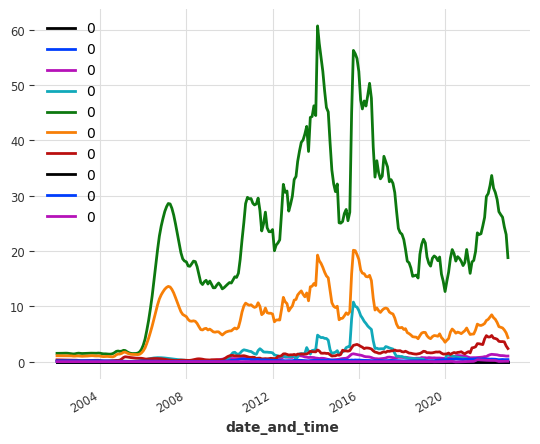

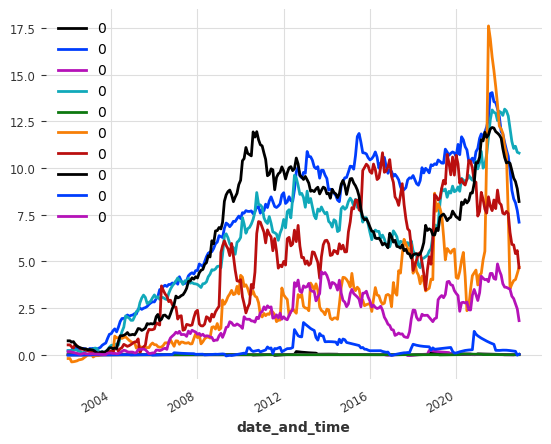

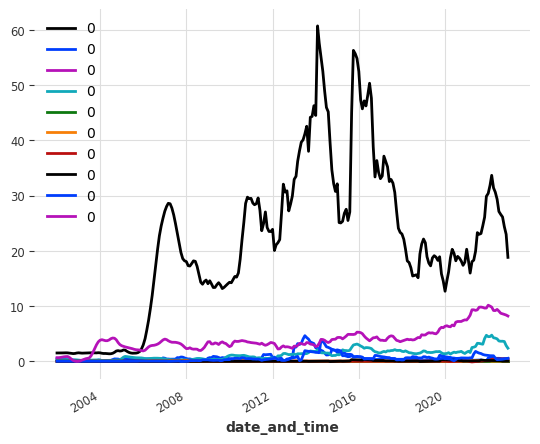

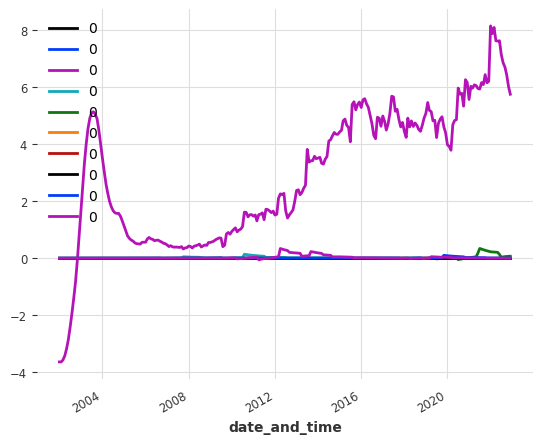

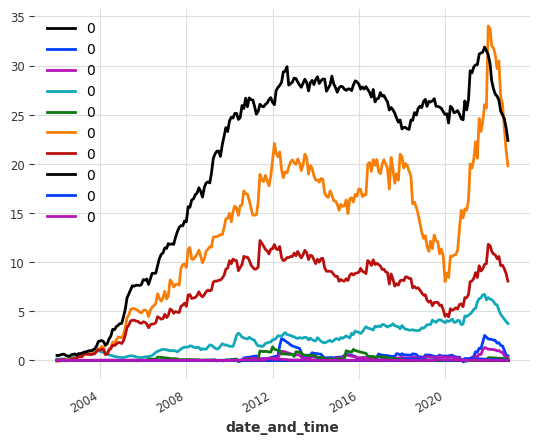

In [452]:
for i in range(1,7):
    mydfnow=dftm.loc[dftm['cluster']==i]

    nowlist =mydfnow['Time serie'].tolist()[40:50]
    for ele in nowlist:
        ele.plot()
    plt.show()

In [453]:
dftm.dtypes

concept1      object
concept2      object
indextype     object
Time serie    object
cluster        int64
dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


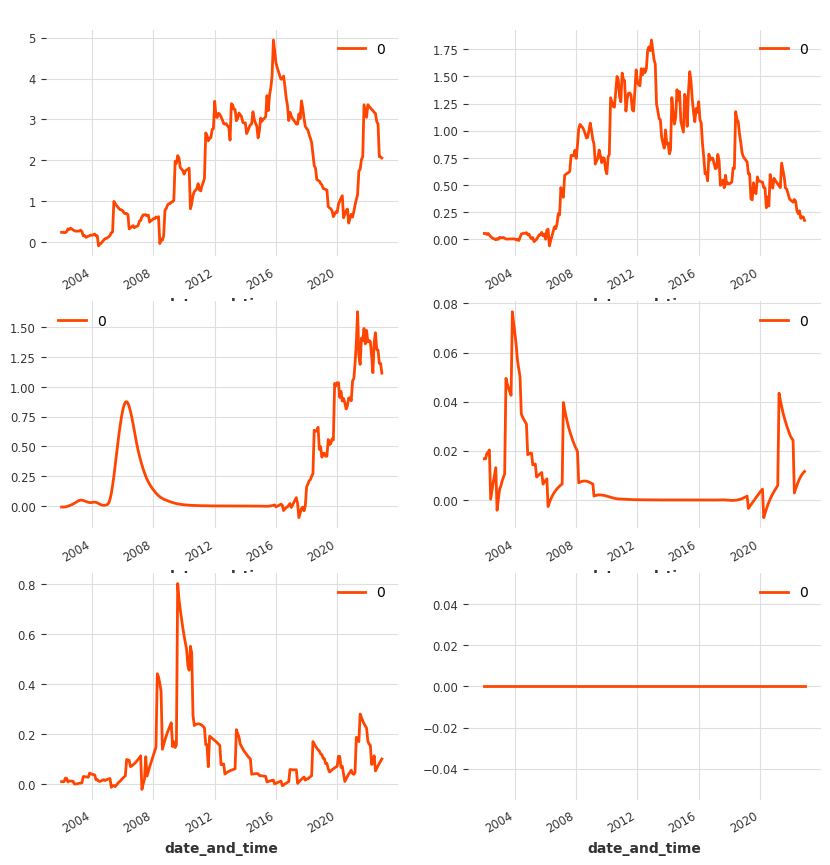

In [454]:
figure, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=100)

for i, idx in enumerate([1, 20, 50, 103, 250, 300]):
    axis = ax[i % 3, i % 2]
    dftm.loc[idx]['Time serie'].plot(ax=axis,c="orangered",lw=2,)
    axis.legend(dftm.loc[idx]['Time serie'].components)
    axis.set_title(" ");

<div class="alert-info">
4. Auxiliary function for forecasting
</div>

Defining auxiliary functions, I will use in my forecasting analyses.

We define a handy function to tell us how good a bunch of forecasted series are:

In [455]:
def mysmape(preds, test_series): 
    listsmapes = []
    vector_local_variances = []
    vector_all_errors = []
    for j in range(len(preds)):
        actual = [x[0] for x in TimeSeries.values(preds[j])]
        forecast=[x[0] for x in TimeSeries.values(test_series[j])]
        actual_new = []
        forecast_new = []
        for i in range(len(actual)):
            if actual[i]!=0 and forecast[i]!=0:
                actual_new.append(actual[i])
                forecast_new.append(forecast[i])
        actual_new = np.array(actual_new)
        forecast_new = np.array(forecast_new)
        listsmapes.append(100*np.sum(2*np.abs(forecast_new - actual_new) / \
        (np.abs(actual_new) + np.abs(forecast_new)))/len(actual))
        
        vector_errors=[]
        for i in range(len(actual)):
            vector_errors.append(abs(actual[i]-forecast[i]))
            
        vector_local_variances.append(np.var(vector_errors))
        
        vector_all_errors = vector_all_errors+vector_errors
    
    var_allerrors = np.var(vector_all_errors)
    var_mean_var = np.mean(vector_local_variances)
    
    return listsmapes,var_allerrors,var_mean_var

In [456]:
def plot_error_var_local(forecaster,horizon,df,mean_allvar):
    model_loaded = forecaster.load("my_model.pkl")
    
    preds = list(TimeSeries.pd_series(model_loaded.predict(n=horizon)))

    actualtm = list(TimeSeries.pd_series(df['Time serie'].tolist()[-1])) 
    
    preds_minusvar =actualtm[:-horizon]
    preds_plusvar = actualtm[:-horizon]
    predictions = actualtm[:-horizon]+preds
    
    for j in range(horizon):
        preds_minusvar.append(preds[j]-np.mean(mean_allvar)) 
        preds_plusvar.append(preds[j]+np.mean(mean_allvar)) 
    
    x_cor =np.arange(0,len(actualtm))
    plt.plot(x_cor,predictions,x_cor,preds_plusvar,x_cor,preds_minusvar)
    
    plt.show()

In [457]:
def plot_error_var_global(forecaster,horizon,df,mean_allvar):
    model_loaded = forecaster.load("my_model.pkl")
    
    preds = list(TimeSeries.pd_series(model_loaded.predict(n=horizon,series=df['Train tm'].tolist()[-1])))

    actualtm = list(TimeSeries.pd_series(df['Time serie'].tolist()[-1])) 
    
    preds_minusvar =actualtm[:-horizon]
    preds_plusvar = actualtm[:-horizon]
    predictions = actualtm[:-horizon]+preds
    
    for j in range(horizon):
        preds_minusvar.append(preds[j]-np.mean(mean_allvar)) 
        preds_plusvar.append(preds[j]+np.mean(mean_allvar)) 
    
    x_cor =np.arange(0,len(actualtm))
    plt.plot(x_cor,predictions,x_cor,preds_plusvar,x_cor,preds_minusvar)
    
    plt.show()

In [458]:
def cross_validation_splitting_window_local(data,horizon,list_concepts,number_cv,modelname,forecaster,**kwargs):
    
    time1=time.time()
    
    maximal_train_len = 252-horizon
    score_forecaster = []
    allsmapes = []
    
    mean_allvar= []
    var_alltheerrors = []
    
    for i in range(number_cv):
        if i<number_cv-1:
            windowslength =maximal_train_len//number_cv
            startingtime = i*windowslength
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_local_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        else:
            windowslength = maximal_train_len-(number_cv-1)*(maximal_train_len//number_cv) # to get the remaining window
            startingtime = i*(maximal_train_len//number_cv)
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_local_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        score_forecaster.append(np.median(smapes))
        allsmapes.append(smapes)
        # I save the mean of the all the smapes done over one window
        
        var_alltheerrors.append(var_allerrors)
        mean_allvar.append(var_mean_var)
        
        
    myscores =np.array(score_forecaster)
    
    time2=time.time()
    elapsed_time = time2-time1
    
    eval_kcross_forecasts(allsmapes,modelname)


    
    return elapsed_time,np.mean(myscores),np.median(myscores),np.mean(var_allerrors),np.mean(mean_allvar)

In [459]:
def cross_validation_expanding_window_local(data,horizon,list_concepts,number_cv,modelname,forecaster,**kwargs):
    
    time1=time.time()
    
    
    startingtime=0
    maximal_train_len = 252-horizon
    score_forecaster = []
    allsmapes = []
    
    mean_allvar= []
    var_alltheerrors = []
    
    for i in range(number_cv):
        if i<number_cv-1:
            windowslength =(i+1)*(maximal_train_len//number_cv)
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_local_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        else:
            windowslength = maximal_train_len
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_local_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
        
        allsmapes.append(smapes)
        
        score_forecaster.append(np.median(smapes))
        # I save the mean of the all the smapes done over one window
        
        var_alltheerrors.append(var_allerrors)
        mean_allvar.append(var_mean_var)
        

    myscores =np.array(score_forecaster)
    
    time2=time.time()
    elapsed_time = time2-time1
        
    eval_kcross_forecasts(allsmapes,modelname)


    return elapsed_time,np.mean(myscores),np.median(myscores),np.mean(var_allerrors),np.mean(mean_allvar)

In [460]:
def cross_validation_splitting_window_global(data,horizon,list_concepts,number_cv,modelname,forecaster,**kwargs):
    
    time1=time.time()
    
    maximal_train_len = 252-horizon
    score_forecaster = []
    allsmapes=[]
    
    mean_allvar= []
    var_alltheerrors = []
    
    for i in range(number_cv):
        if i<number_cv-1:
            windowslength =maximal_train_len//number_cv
            startingtime = i*windowslength
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        else:
            windowslength = maximal_train_len-(number_cv-1)*(maximal_train_len//number_cv) # to get the remaining window
            startingtime = i*(maximal_train_len//number_cv)
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
        
        allsmapes.append(smapes)
        score_forecaster.append(np.median(smapes))
        # I save the mean of the all the smapes done over one window
        
        var_alltheerrors.append(var_allerrors)
        mean_allvar.append(var_mean_var)
        
    myscores =np.array(score_forecaster)
    
    time2=time.time()
    elapsed_time = time2-time1
    
    eval_kcross_forecasts(allsmapes,modelname)
    
    return elapsed_time,np.mean(myscores),np.median(myscores),np.mean(var_allerrors),np.mean(mean_allvar)

In [461]:
def cross_validation_expanding_window_global(data,horizon,list_concepts,number_cv,modelname,forecaster,**kwargs):
    
    time1=time.time()
    
    startingtime=0
    maximal_train_len = 252-horizon
    score_forecaster = []
    allsmapes=[]
    
    mean_allvar= []
    var_alltheerrors = []
    
    for i in range(number_cv):
        if i<number_cv-1:
            windowslength =(i+1)*(maximal_train_len//number_cv)
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        else:
            windowslength = maximal_train_len
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        
        allsmapes.append(smapes)
        score_forecaster.append(np.median(smapes))
        # I save the mean of the all the smapes done over one window
        
        var_alltheerrors.append(var_allerrors)
        mean_allvar.append(var_mean_var)

    myscores =np.array(score_forecaster)
    
    time2=time.time()
    elapsed_time = time2-time1
    
    eval_kcross_forecasts(allsmapes,modelname)

    return elapsed_time,np.mean(myscores),np.median(myscores),np.mean(var_allerrors),np.mean(mean_allvar)

In [462]:
def creating_train_test_tm(dftm,startingtime,windowslength,horizon,list_concepts):

    listconcept1=[]
    listconcept2=[]
    listindextype=[]
    
    listdartstm=[]
    listtraintm=[]
    listtesttm=[]
    listcluster=[]

    for concept1 in list_concepts:
        dfconcept1 = dftm.loc[dftm['concept1']==concept1]
        for concept2 in list_concepts:
            dfconcept2 = dfconcept1.loc[dfconcept1['concept2']==concept2]
            for index in list_indices:
                dfindex=dfconcept2.loc[dfconcept2['indextype']==index]
                if len(dfindex)!=0:
                    
                    mycluster = dfindex.cluster.tolist()[0]
                    mytimeseries=dfindex['Time serie'].tolist()[0]
                    if startingtime==0:
                        traintm=mytimeseries[:windowslength]
                    else:
                        traintm=mytimeseries[startingtime-1:startingtime+windowslength]
                        
                    testtm=mytimeseries[startingtime+windowslength:startingtime+windowslength+horizon]
                                    
                    listconcept1.append(concept1)
                    listconcept2.append(concept2)
                    listindextype.append(index)
                    listdartstm.append(mytimeseries)
                    listtraintm.append(traintm)
                    listtesttm.append(testtm)
                    listcluster.append(mycluster)
                    
    df = pd.DataFrame({'concept1':listconcept1,'concept2':listconcept2,'indextype':listindextype,
                         'Time serie':listdartstm,'Train tm':listtraintm,'Test tm':listtesttm,'cluster':listcluster})
    return df

In [463]:
def eval_kcross_forecasts(smapes,modelname):
    
    plt.figure(figsize=(10, 5))
    
    themedians = []
    labels = []
    
    for i in range(len(smapes)):
        themedians.append(np.median(smapes[i]))
        #plt.hist(smapes[i], bins=100,label='K-cross set'+str(i+1))
        labels = labels +['Trained on '+str((i+1)*(100//len(smapes)))+\
        ' % of the data, with a median smape of '+ str(round(np.median(smapes[i]),2))+' %.']
        
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("The median sMAPE for "+str(modelname)+" : %.3f" % np.median(themedians))
    #plt.yscale('log')

    plt.hist(smapes,bins=100,histtype='barstacked',label=labels)
    
    plt.legend()
    plt.show()
    plt.close()

In [464]:
def eval_local_model(train_series, test_series,horizon, model_cls, **kwargs):
    preds = []

    for series in tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=horizon)
        preds.append(pred)
    
    smapes,var_allerrors,var_mean_var = mysmape(preds, test_series)
    
    model.save("my_model.pkl")
    
    return smapes,var_allerrors,var_mean_var

In [465]:
def eval_global_model(train_series, test_series,horizon, model_cls, **kwargs):
    model = model_cls(**kwargs)

    if model_cls==NBEATSModel:
        model.fit(train_series, num_loader_workers=4, epochs=10)
    else:
        model.fit(train_series)
    preds = model.predict(n=horizon, series=train_series)

    smapes,var_allerrors,var_mean_var = mysmape(preds, test_series)
    
    model.save("my_model.pkl")
    
    return smapes,var_allerrors,var_mean_var

In [466]:
def plot_models(method_to_elapsed_times, method_to_smapes):
    shapes = ["o", "s", "*"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]
    styles = list(product(shapes, colors))

    plt.figure(figsize=(6, 6), dpi=100)

    for i, method in enumerate(method_to_elapsed_times.keys()):

        t = method_to_elapsed_times[method]
        s = styles[i]
        plt.semilogx(
            [t],
            [np.mean(method_to_smapes[method])],
            s[0],
            color=s[1],
            label=method,
            markersize=13,
        )
    plt.xlabel("elapsed time [s]")
    plt.ylabel("Average sMAPE over all series")
    plt.legend(bbox_to_anchor=(1.4, 1.0), frameon=True)
    plt.show();

In [467]:
def plot_models_cluster(method_to_elapsed_times, method_to_smapes):
    shapes = ["o", "s", "*"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]
    styles = list(product(shapes, colors))

    plt.figure(figsize=(6, 6), dpi=100)

    for i, method in enumerate(method_to_elapsed_times.keys()):

        t = method_to_elapsed_times[method]
        s = styles[i]
        plt.semilogx(
            [t],
            [np.mean(method_to_smapes[method])],
            s[0],
            color=s[1],
            label=method,
            markersize=13,
        )
    plt.xlabel("elapsed time [s]")
    plt.ylabel("Average sMAPE over all series")
    plt.legend(bbox_to_anchor=(1.4, 1.0), frameon=True)
    plt.show();

# **Part 1 -- Local forecasting**

Creating the dataframe I will use with an horizon of 3 months.

In [468]:
def local_forecasting(dftm,horizon,list_concepts,number_cv):
    
    # once I created my dataframe with this specific horizon I train and visualize the results of the forecasting algorithms
    
    naive1_time,naive1_smapes_mean,naive1_smapes_med,naive1_var_allerrors,naive1_mean_allvar =\
    cross_validation_expanding_window_local(dftm,\
    horizon,list_concepts,number_cv,'NaiveSeasonal K=1',NaiveSeasonal, K=1)
    
    naive12_time,naive12_smapes_mean,naive12_smapes_med,naive12_var_allerrors,naive12_mean_allvar\
    =cross_validation_expanding_window_local(dftm,\
    horizon,list_concepts,number_cv,'NaiveSeasonal K=12', NaiveSeasonal, K=12)
    
    ets_time,ets_smapes_mean,ets_smapes_med,ets_var_allerrors,ets_mean_allvar\
    =cross_validation_expanding_window_local(dftm,\
    horizon,list_concepts,number_cv,'ExponentialSmoothing',ExponentialSmoothing)
    
    theta_time,theta_smapes_mean,theta_smapes_med,theta_var_allerrors,theta_mean_allvar\
    =cross_validation_expanding_window_local(dftm,\
    horizon,list_concepts,number_cv,'Theta', Theta, theta=1.5,season_mode=SeasonalityMode.ADDITIVE)
    
    
    smapes_mean = {
    "naive-last": naive1_smapes_mean,
    "naive-seasonal": naive12_smapes_mean,
    "Exponential Smoothing": ets_smapes_mean,
    "Theta": theta_smapes_mean
    }
    
    smapes_med = {
    "naive-last": naive1_smapes_med,
    "naive-seasonal": naive12_smapes_med,
    "Exponential Smoothing": ets_smapes_med,
    "Theta": theta_smapes_med
    }

    elapsed_times = {
    "naive-last": naive1_time,
    "naive-seasonal": naive12_time,
    "Exponential Smoothing": ets_time,
    "Theta": theta_time
    }
    
    # We compare models with respect to precision and computational cost.
    print('Visualization of performances taking the mean of the smapes over cross-validation')
    plot_models(elapsed_times, smapes_mean)
    
    print('Visualization of performances taking the median of the smapes over cross-validation')
    plot_models(elapsed_times, smapes_med)
    
    return naive1_smapes_mean,naive12_smapes_mean,ets_smapes_mean,theta_smapes_mean,naive1_var_allerrors,naive1_mean_allvar,naive12_var_allerrors,naive12_mean_allvar,ets_var_allerrors,ets_mean_allvar,theta_var_allerrors,theta_mean_allvar

In [469]:
list_indices=['index_cit_t1_t2','index_cit_t2_t1','index_colab_increm','index_colab_notincrem','index_keyword']

In [470]:
dftm

concept1                  concept2  \
0     Authentication protocole  Authentication protocole   
1     Authentication protocole  Authentication protocole   
2     Authentication protocole  Authentication protocole   
3     Authentication protocole  Authentication protocole   
4     Authentication protocole  Authentication protocole   
...                        ...                       ...   
2345      Zero-knowlegde proof      Zero-knowlegde proof   
2346      Zero-knowlegde proof      Zero-knowlegde proof   
2347      Zero-knowlegde proof      Zero-knowlegde proof   
2348      Zero-knowlegde proof      Zero-knowlegde proof   
2349      Zero-knowlegde proof      Zero-knowlegde proof   

                  indextype  \
0           index_cit_t1_t2   
1           index_cit_t2_t1   
2        index_colab_increm   
3     index_colab_notincrem   
4             index_keyword   
...                     ...   
2345        index_cit_t1_t2   
2346        index_cit_t2_t1   
2347     index_colab_increm   
2348  index_colab_notincrem   
2349          index_keyword   

                                             Time serie  cluster  
0     (((<TimeSeries (DataArray) (date_and_time: 1, ...        1  
1     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
2     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
3     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
4     (((<TimeSeries (DataArray) (date_and_time: 1, ...        6  
...                                                 ...      ...  
2345  (((<TimeSeries (DataArray) (date_and_time: 1, ...        2  
2346  (((<TimeSeries (DataArray) (date_and_time: 1, ...        2  
2347  (((<TimeSeries (DataArray) (date_and_time: 1, ...        3  
2348  (((<TimeSeries (DataArray) (date_and_time: 1, ...        5  
2349  (((<TimeSeries (DataArray) (date_and_time: 1, ...        2  

[2350 rows x 5 columns]

The results for index_cit_t1_t2 are:
The results for index_cit_t1_t2 with an horizon of 3 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

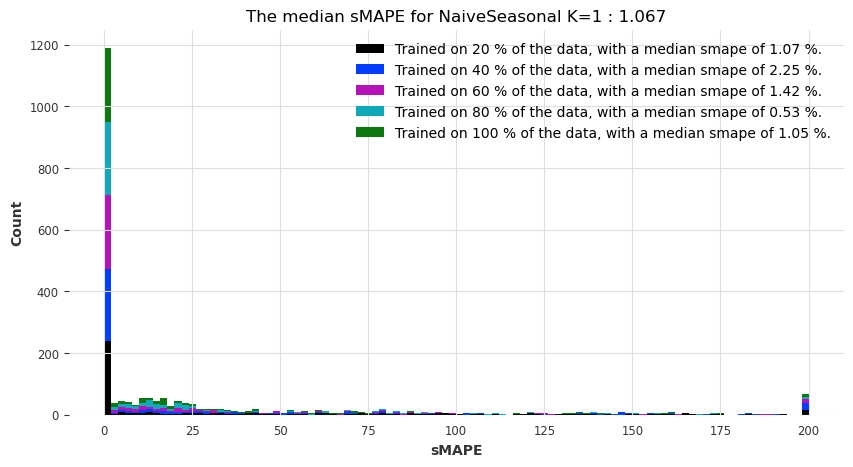

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

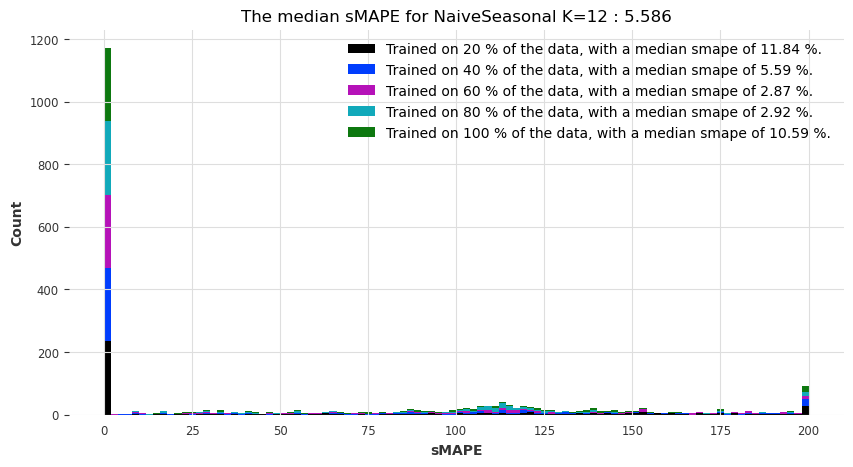

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

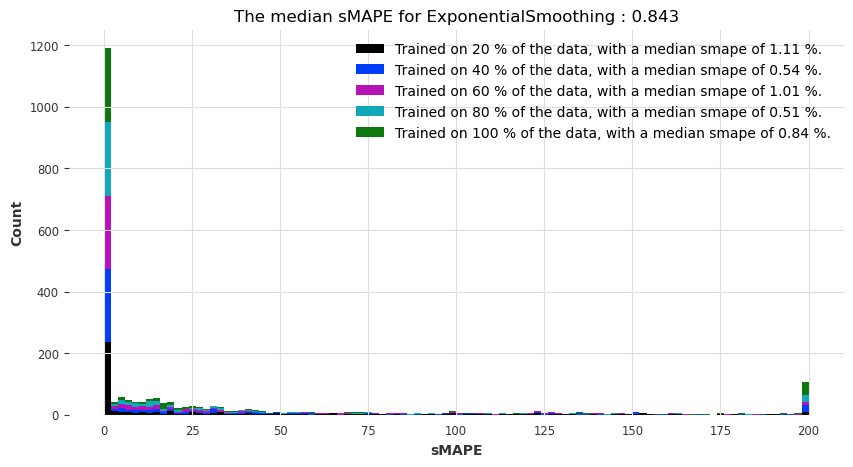

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

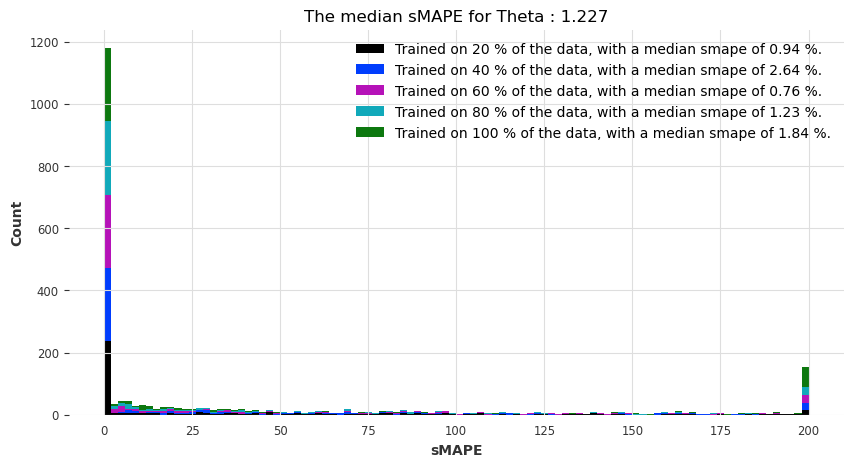

Visualization of performances taking the mean of the smapes over cross-validation


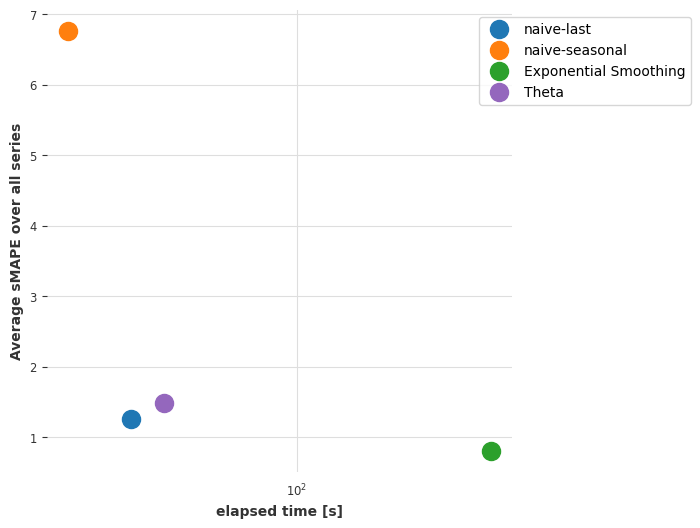

Visualization of performances taking the median of the smapes over cross-validation


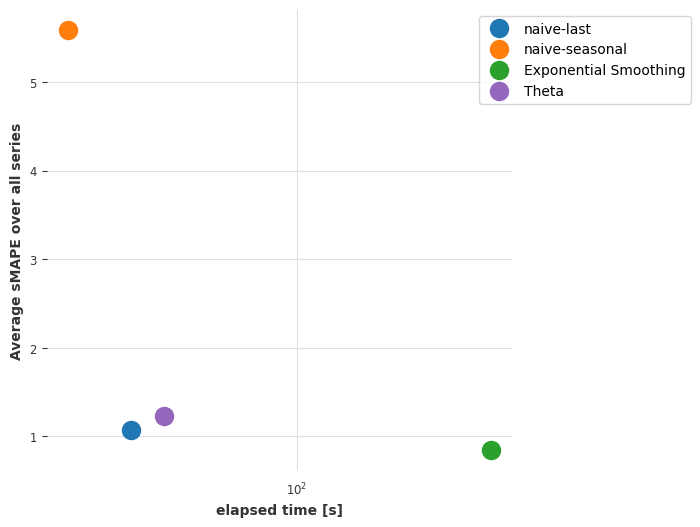

The results for index_cit_t1_t2 with an horizon of 6 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

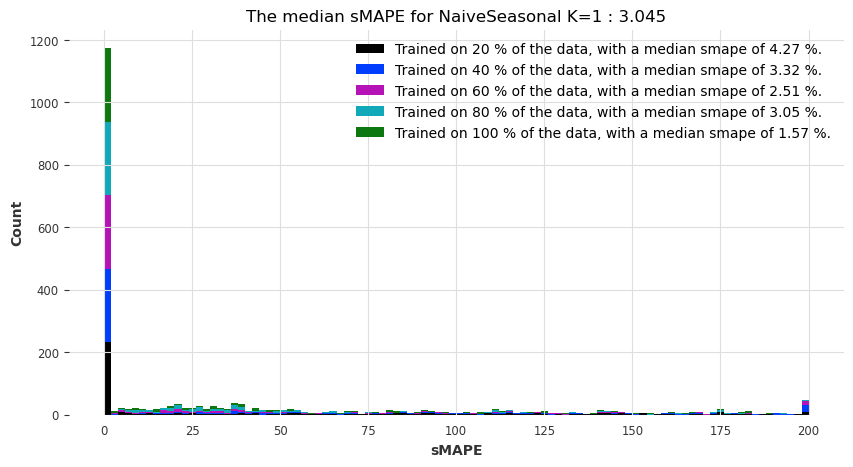

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

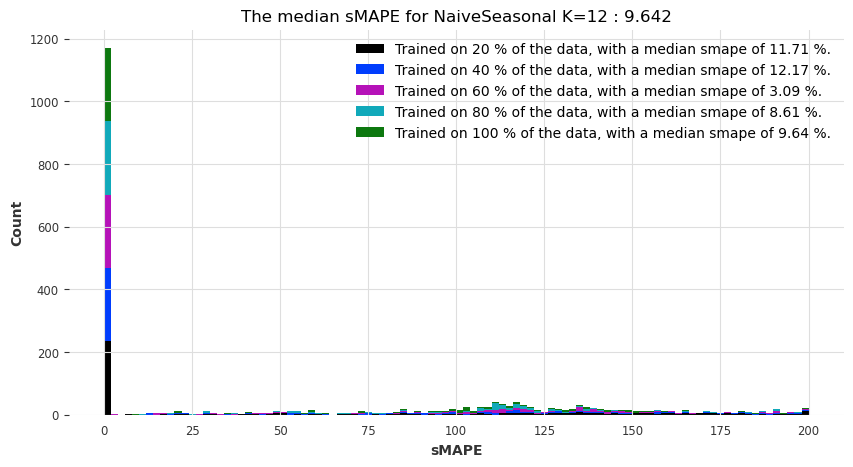

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

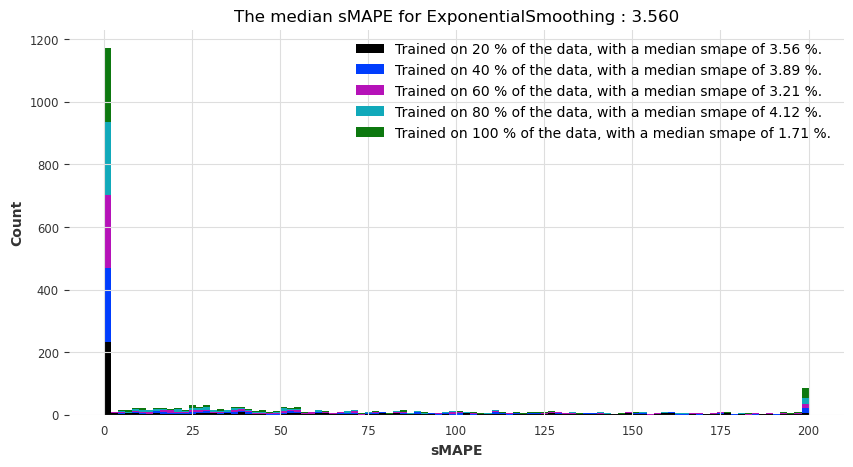

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

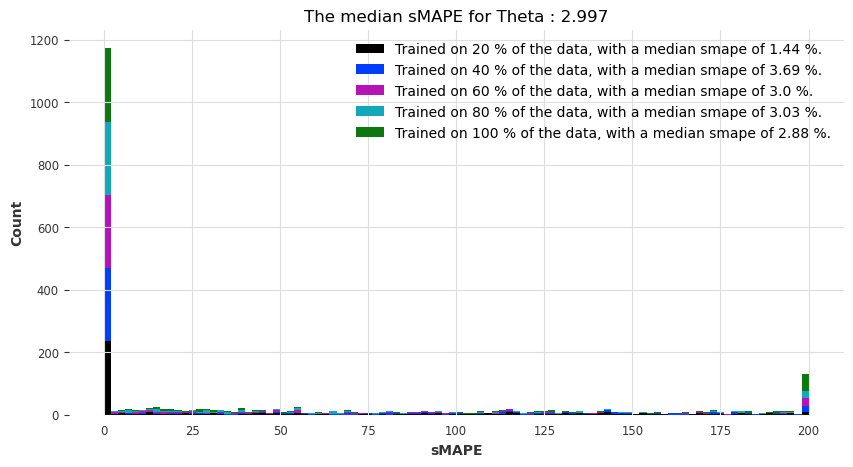

Visualization of performances taking the mean of the smapes over cross-validation


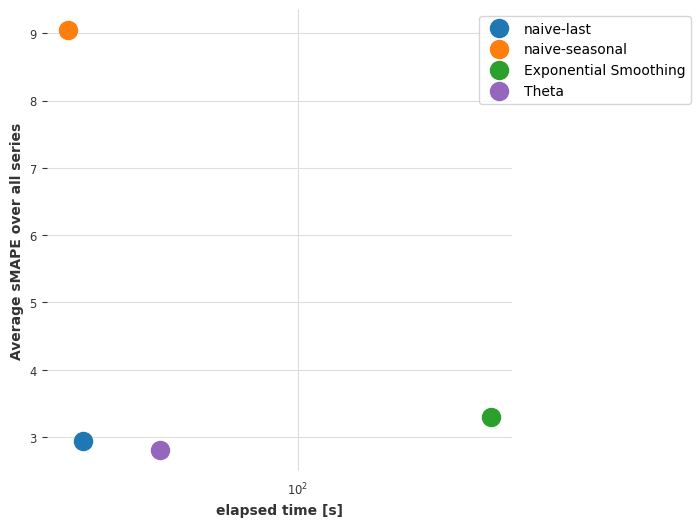

Visualization of performances taking the median of the smapes over cross-validation


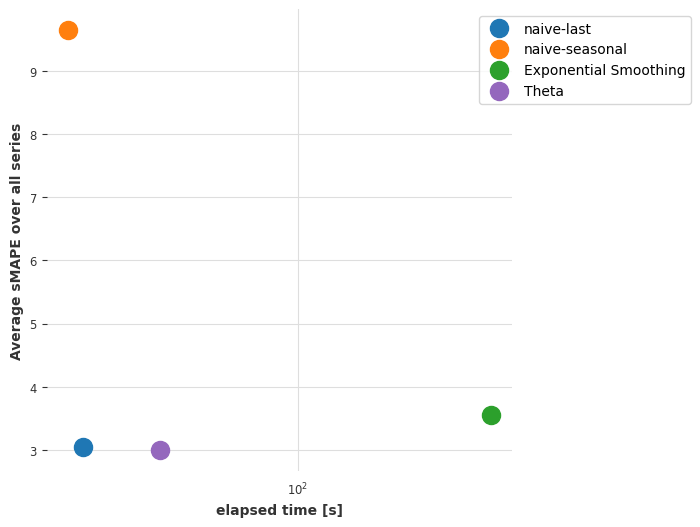

The results for index_cit_t1_t2 with an horizon of 12 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

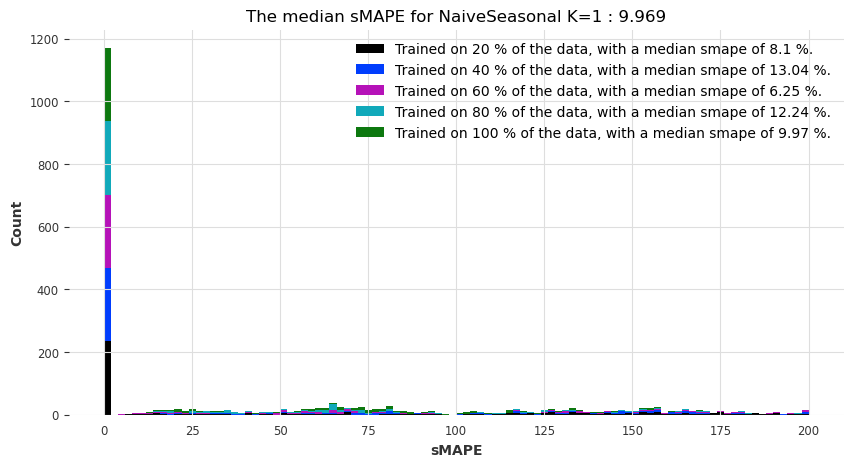

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

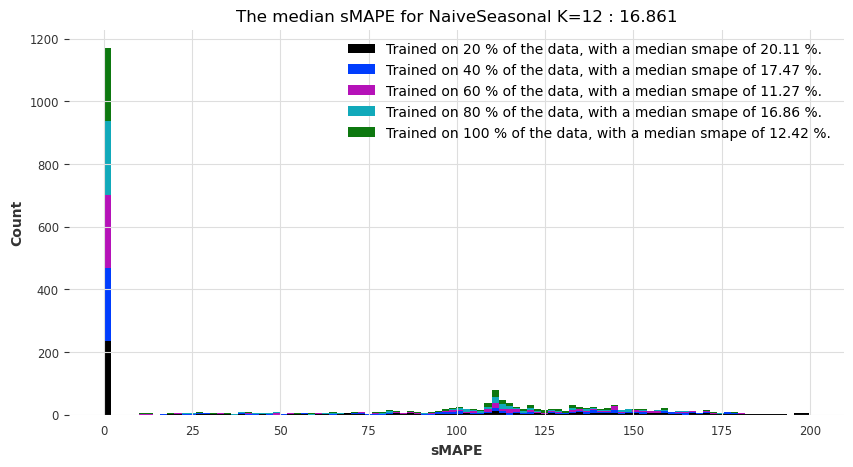

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

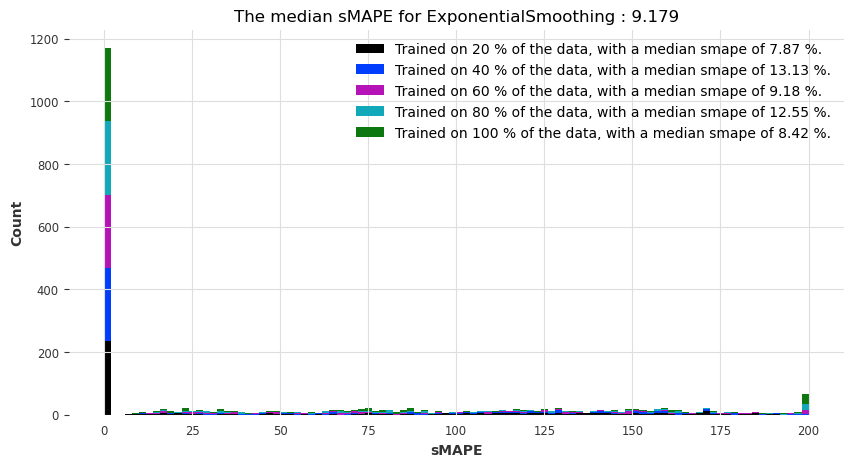

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

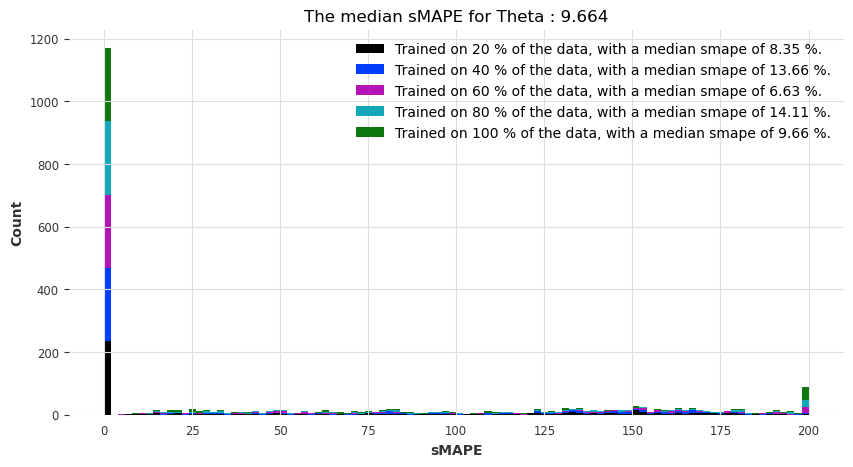

Visualization of performances taking the mean of the smapes over cross-validation


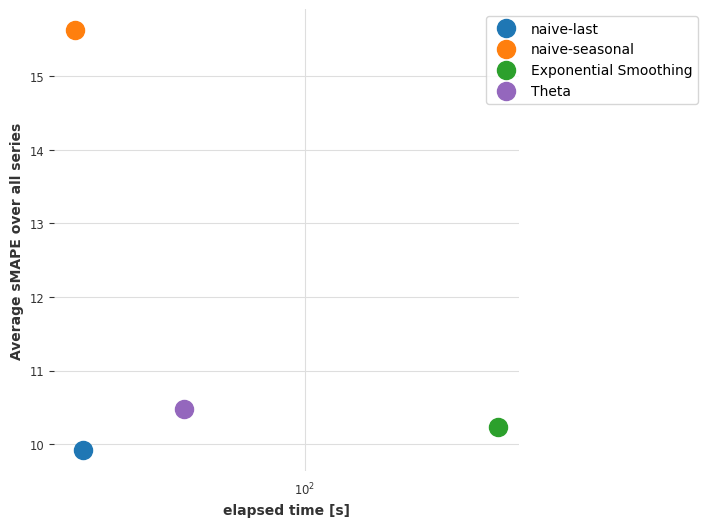

Visualization of performances taking the median of the smapes over cross-validation


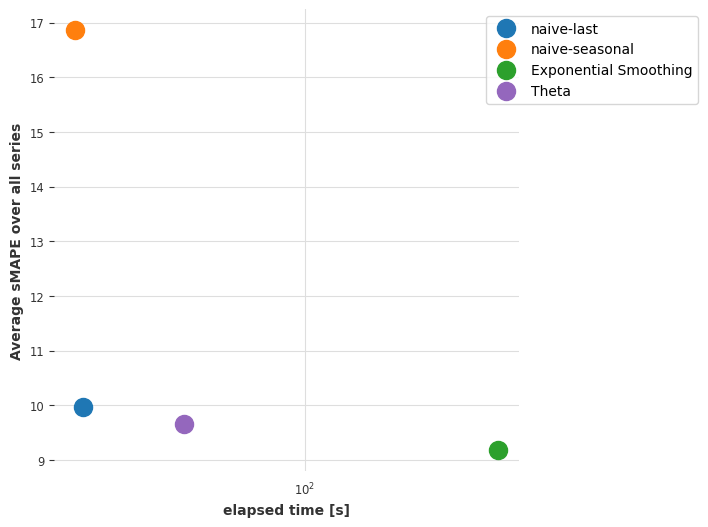

The results for index_cit_t2_t1 are:
The results for index_cit_t2_t1 with an horizon of 3 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

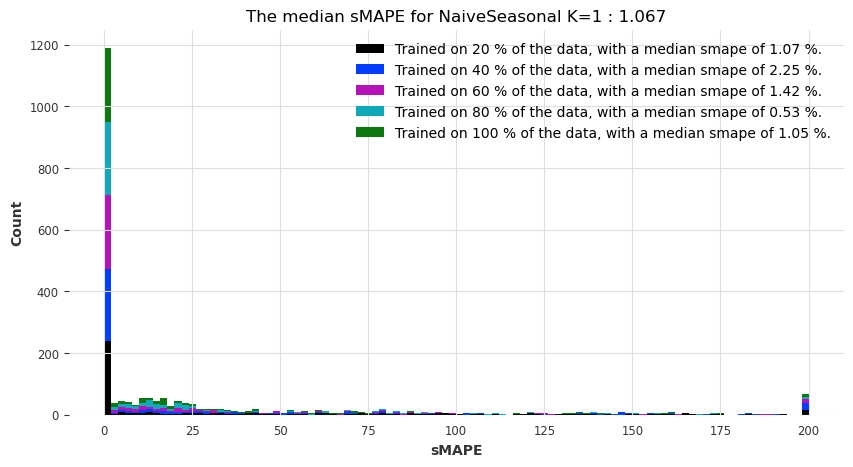

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

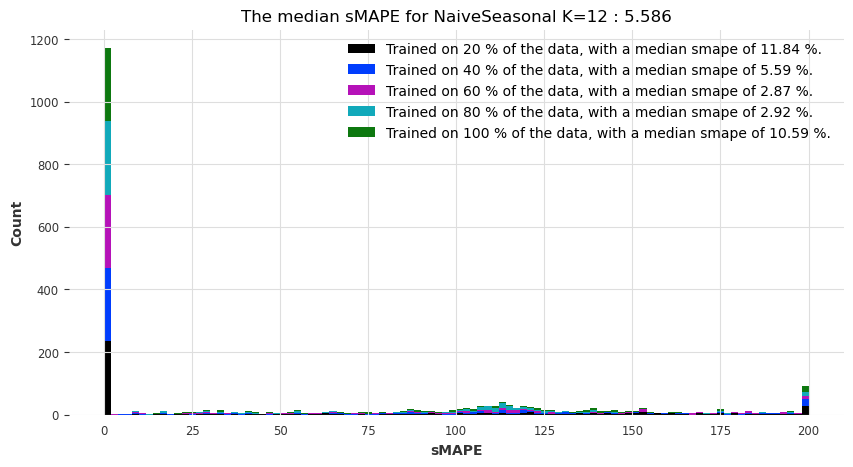

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

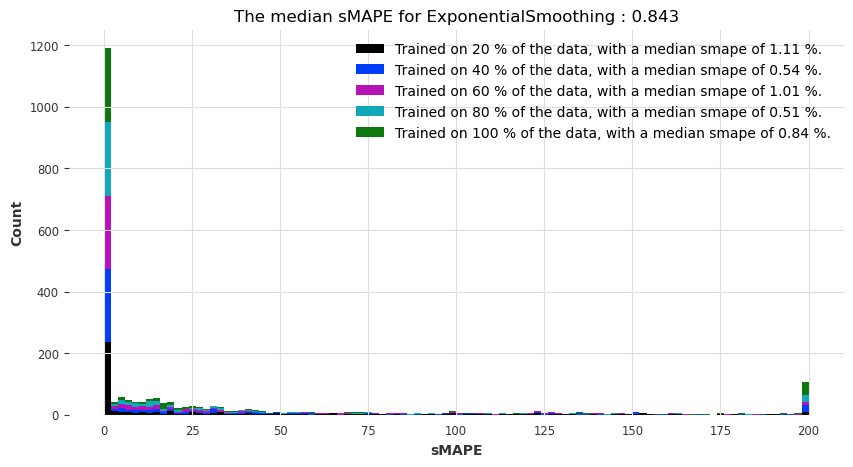

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

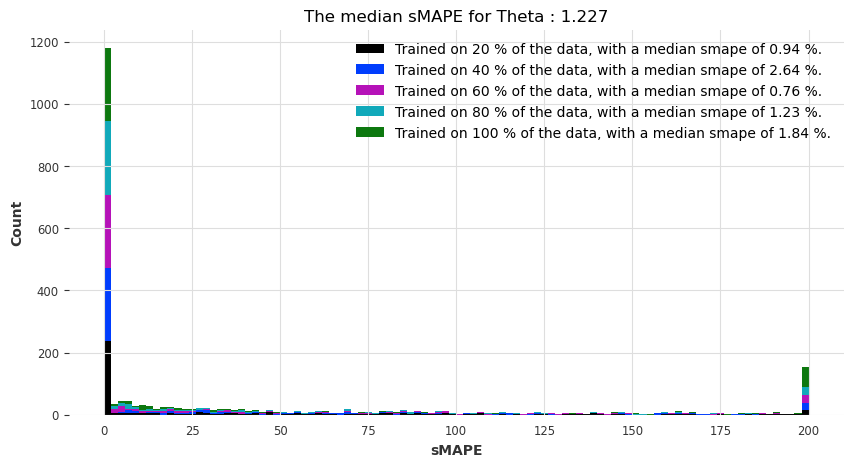

Visualization of performances taking the mean of the smapes over cross-validation


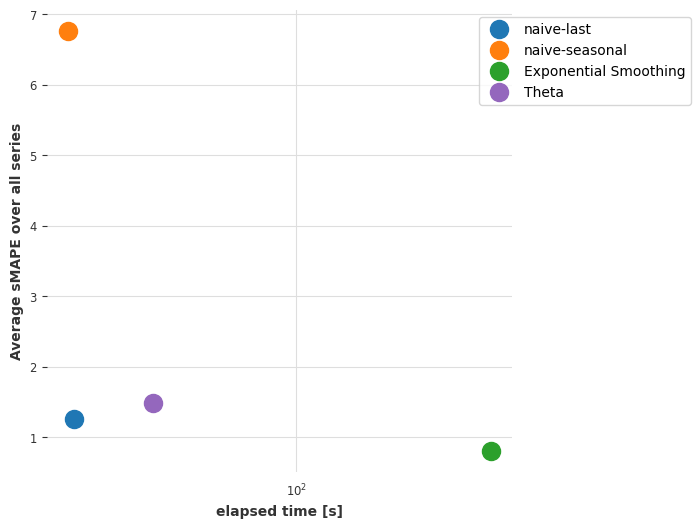

Visualization of performances taking the median of the smapes over cross-validation


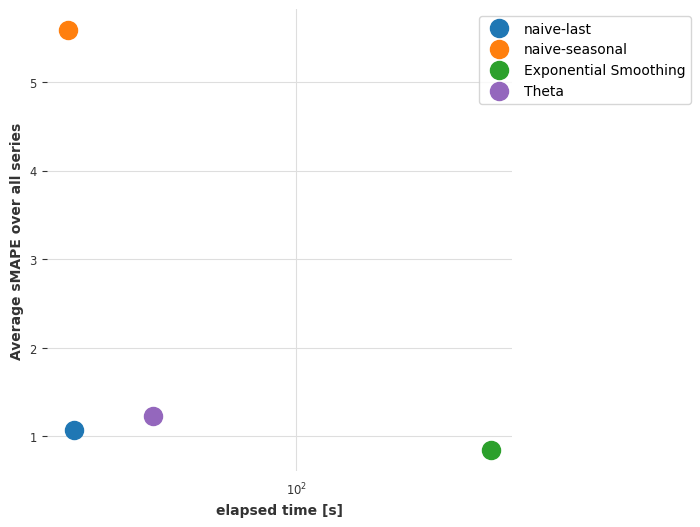

The results for index_cit_t2_t1 with an horizon of 6 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

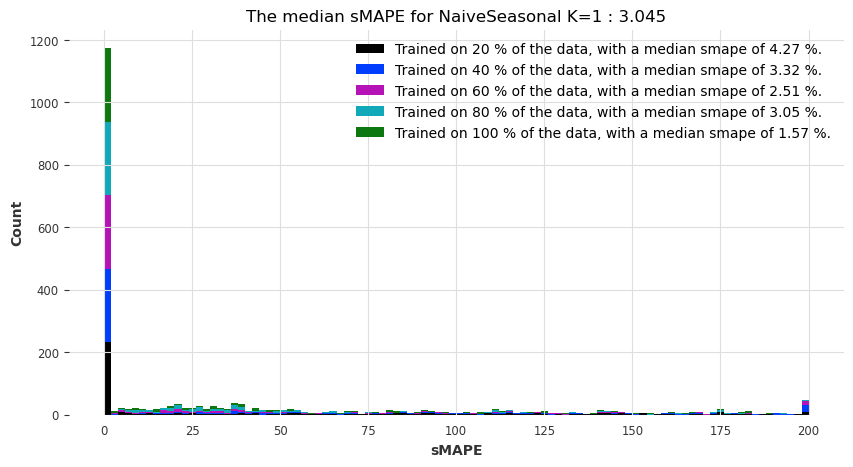

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

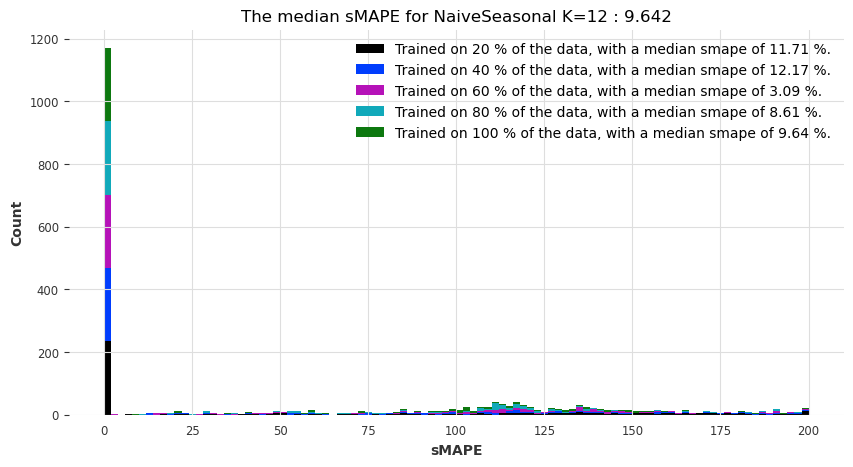

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

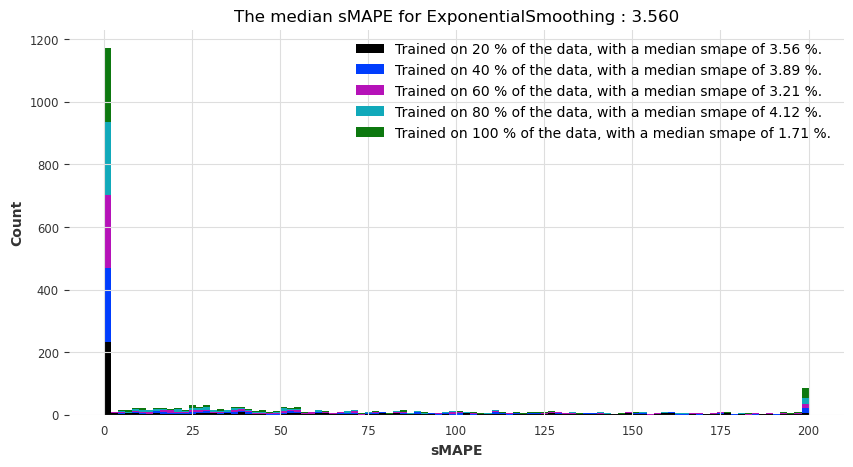

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

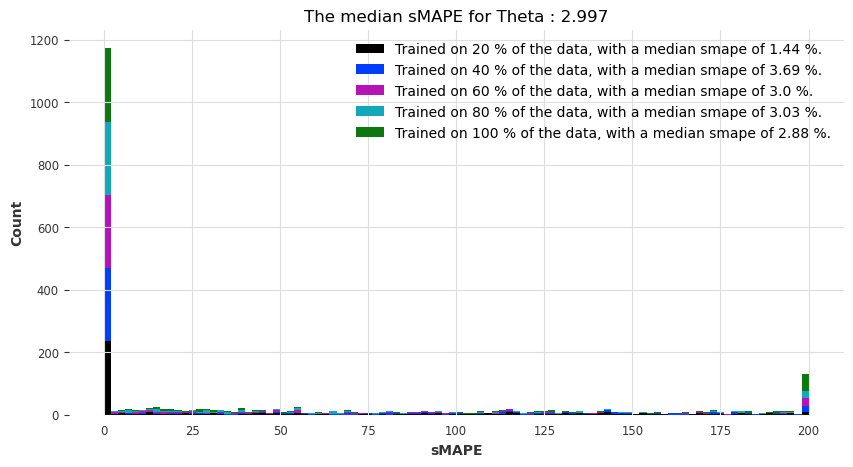

Visualization of performances taking the mean of the smapes over cross-validation


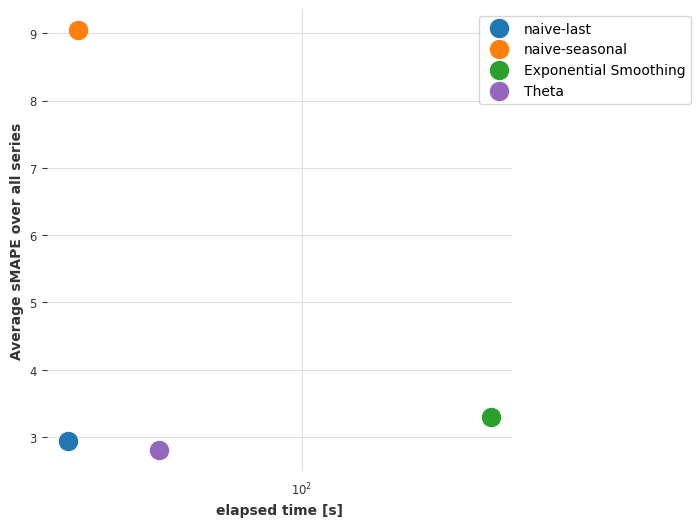

Visualization of performances taking the median of the smapes over cross-validation


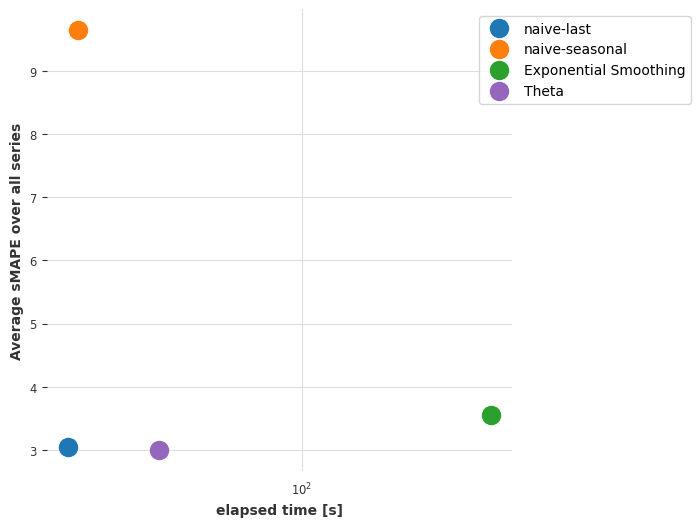

The results for index_cit_t2_t1 with an horizon of 12 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

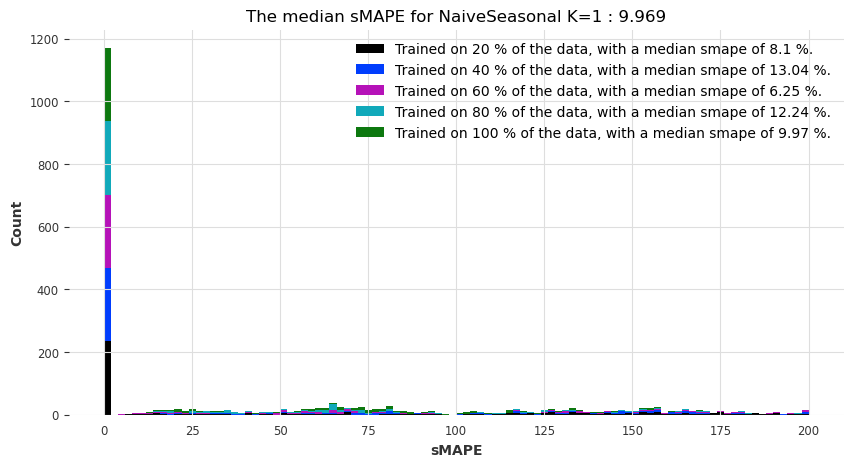

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

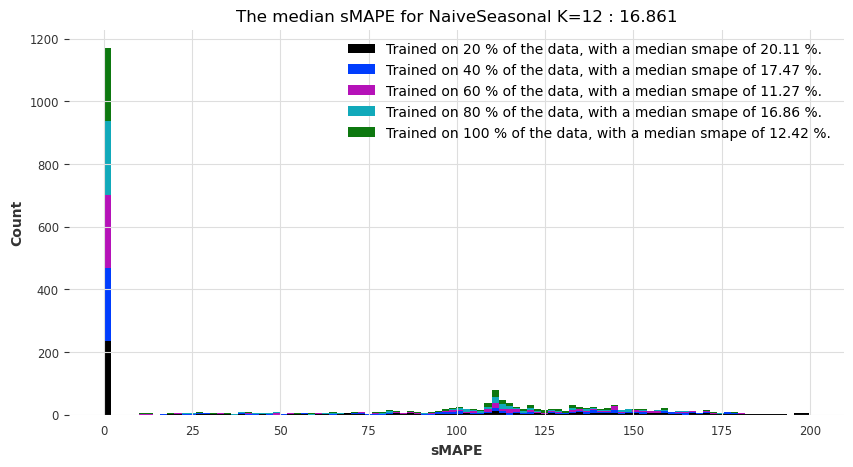

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

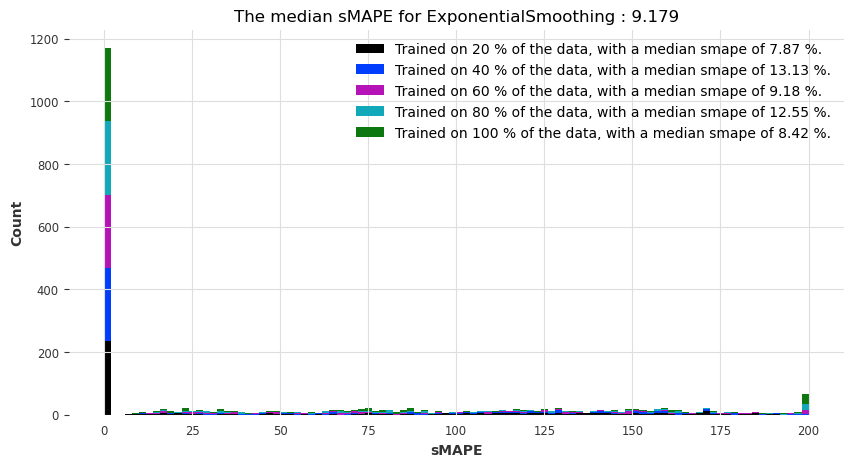

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

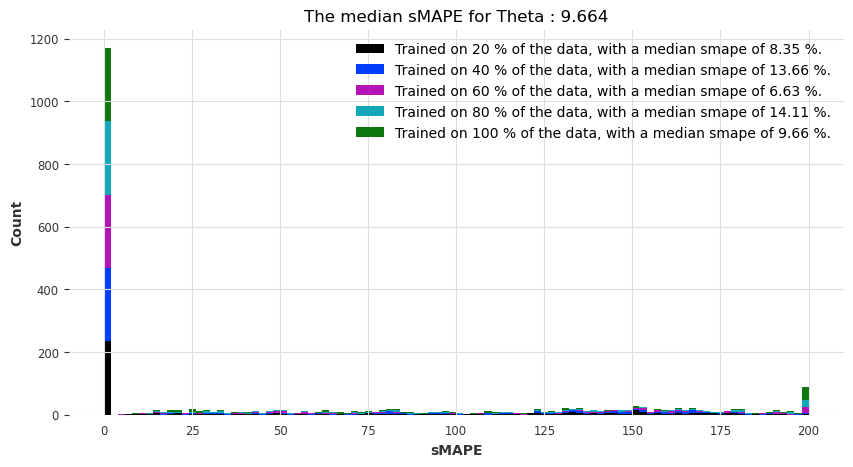

Visualization of performances taking the mean of the smapes over cross-validation


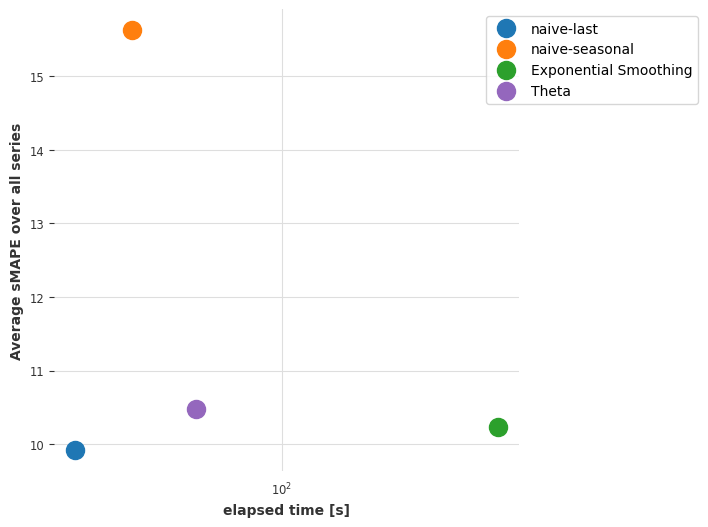

Visualization of performances taking the median of the smapes over cross-validation


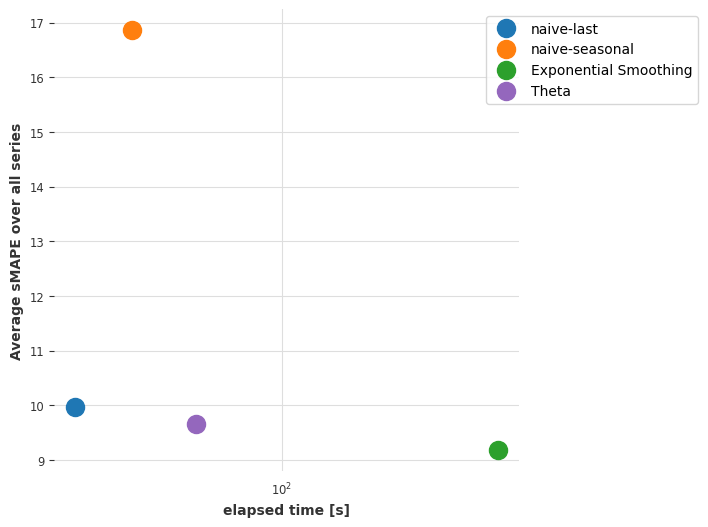

The results for index_colab_increm are:
The results for index_colab_increm with an horizon of 3 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

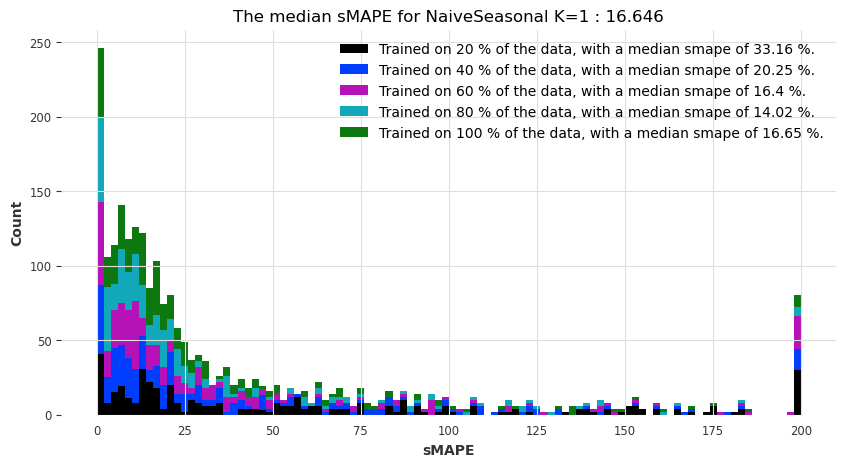

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

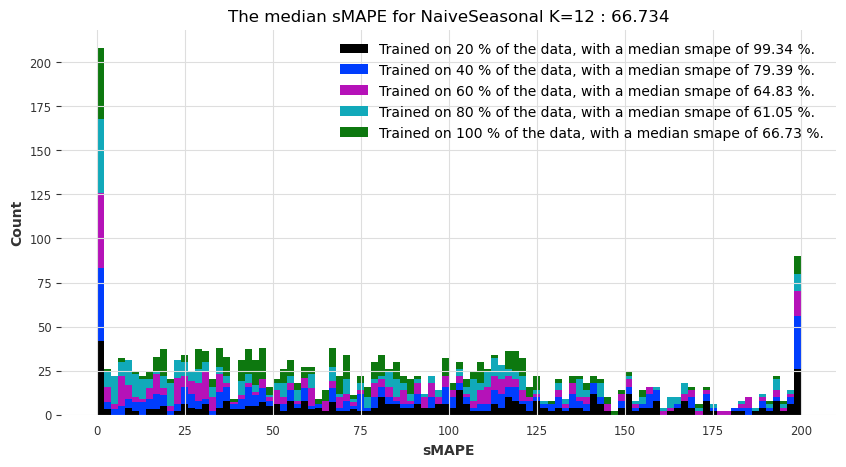

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

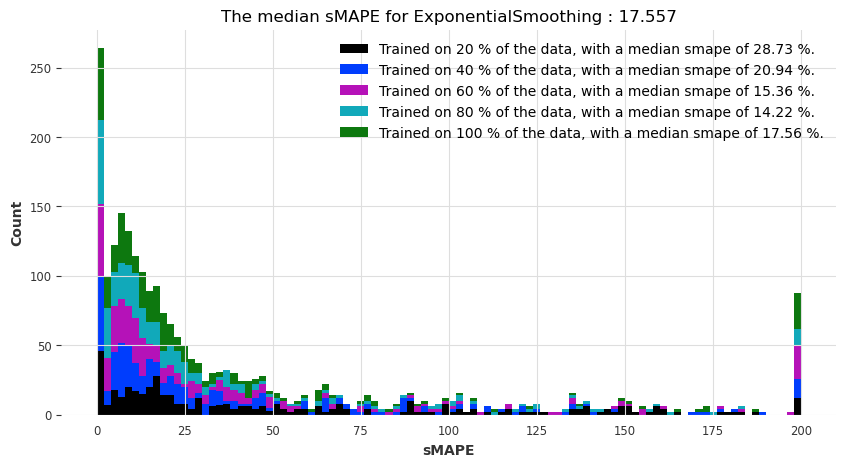

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

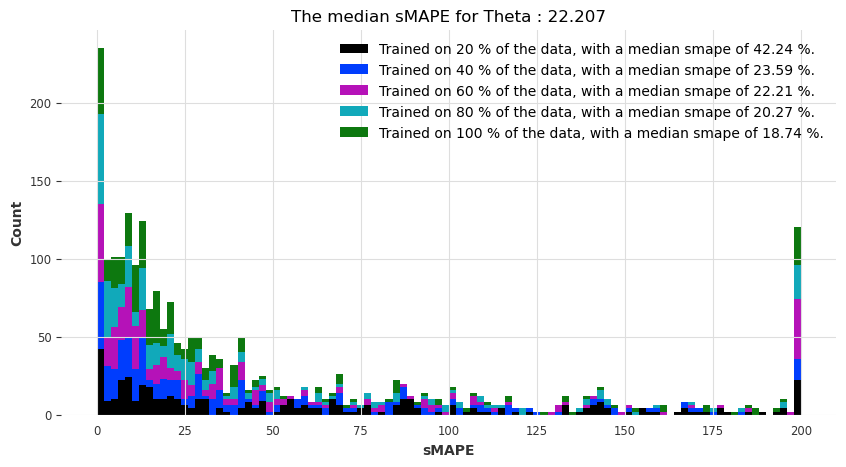

Visualization of performances taking the mean of the smapes over cross-validation


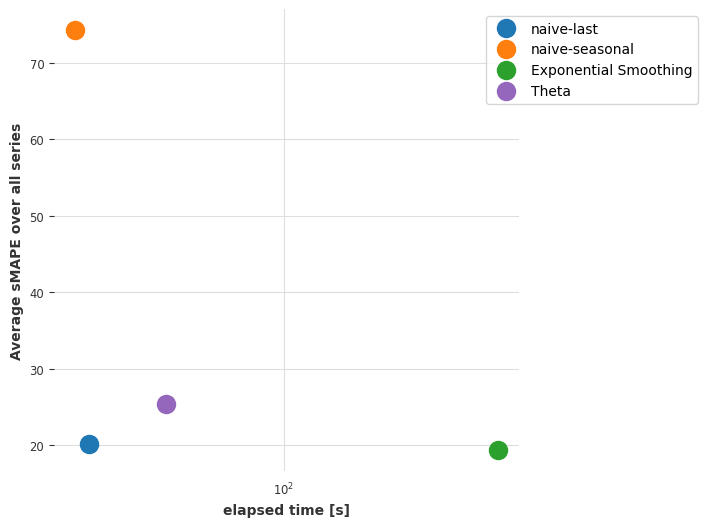

Visualization of performances taking the median of the smapes over cross-validation


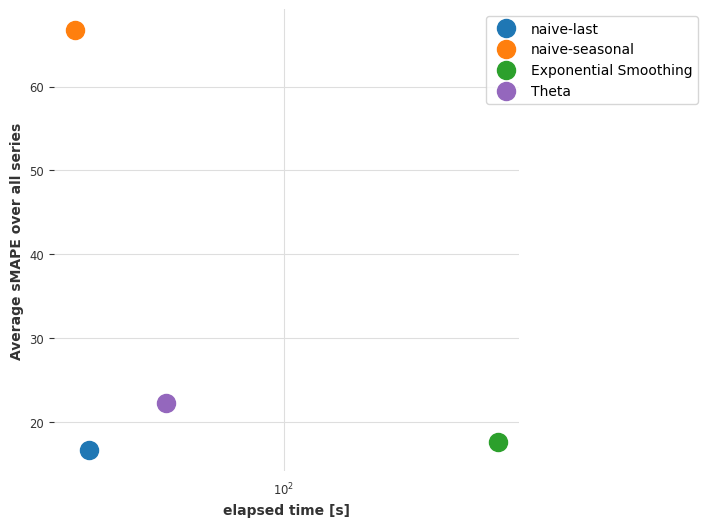

The results for index_colab_increm with an horizon of 6 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

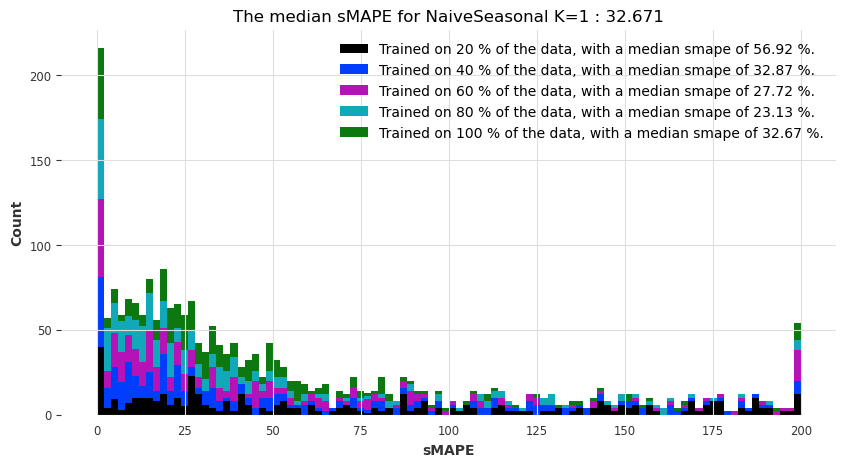

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

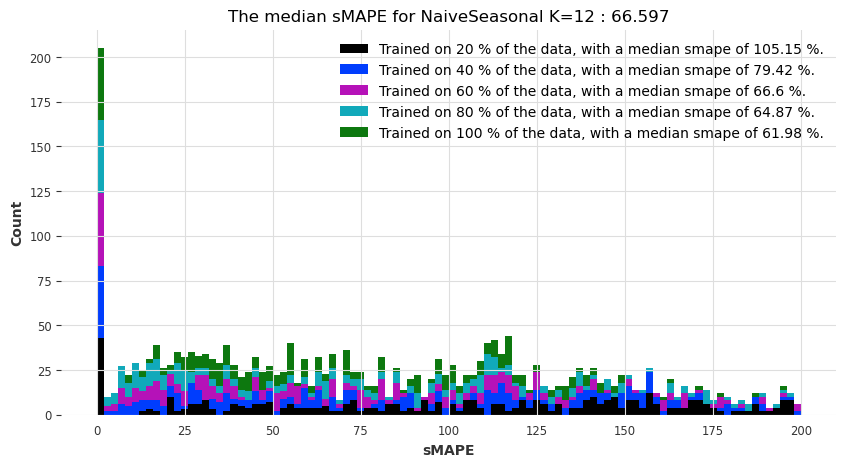

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

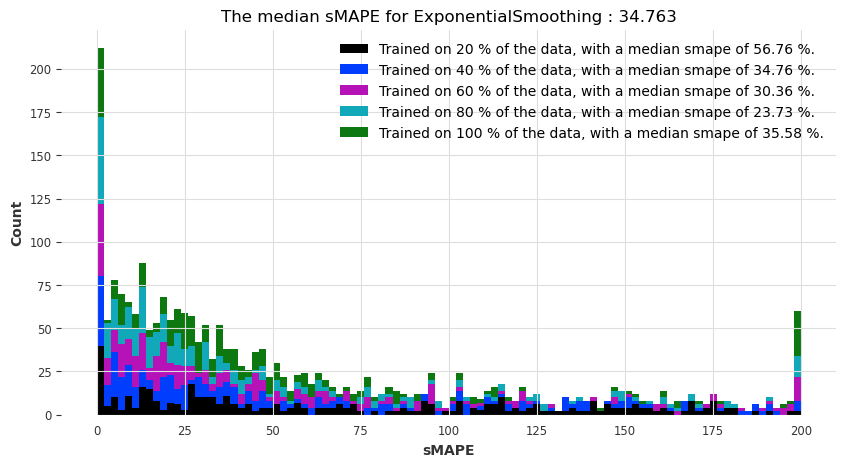

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

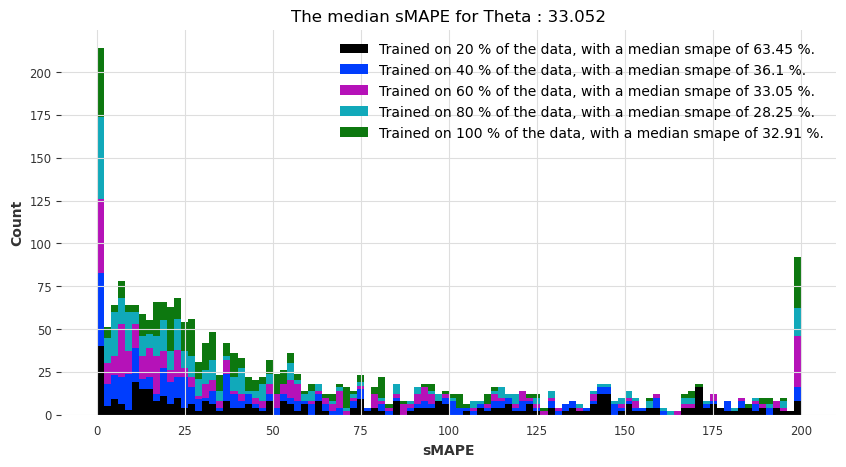

Visualization of performances taking the mean of the smapes over cross-validation


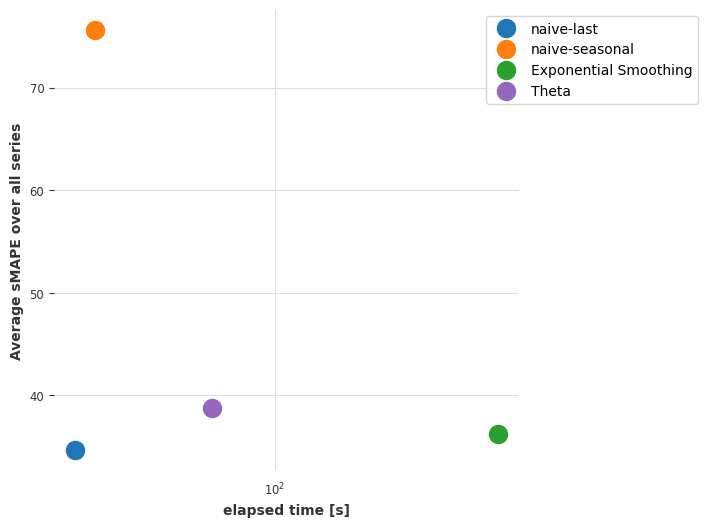

Visualization of performances taking the median of the smapes over cross-validation


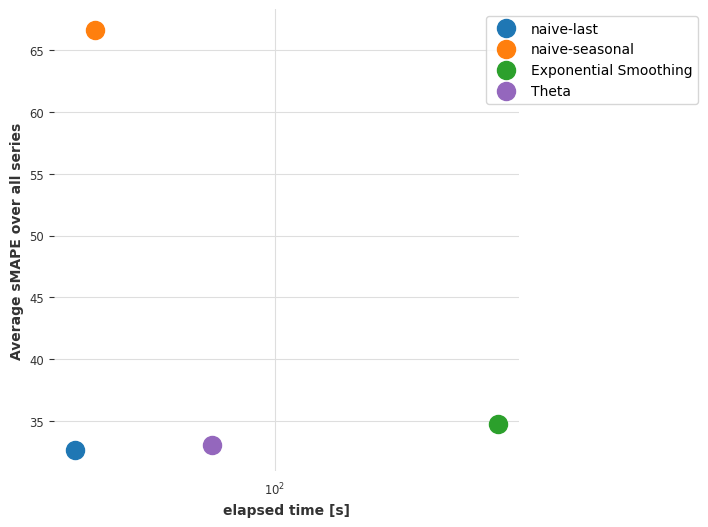

The results for index_colab_increm with an horizon of 12 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

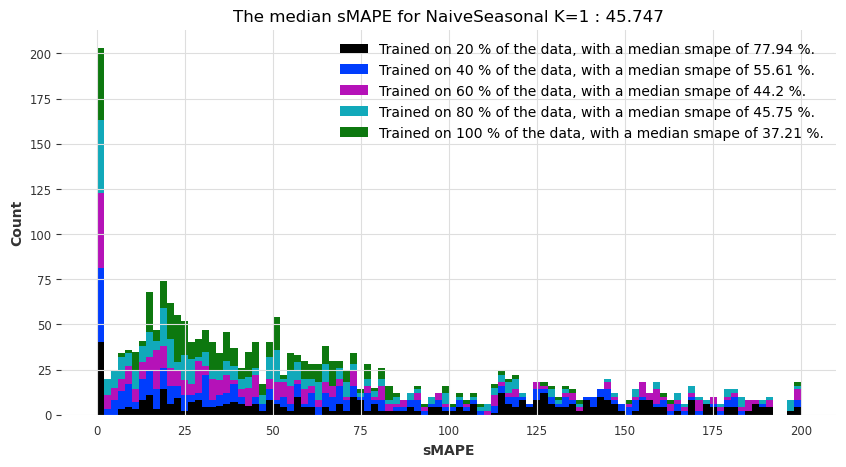

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

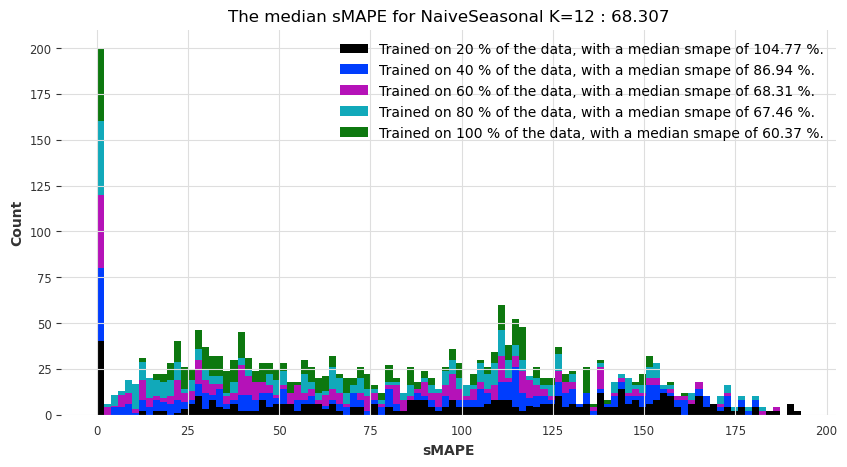

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

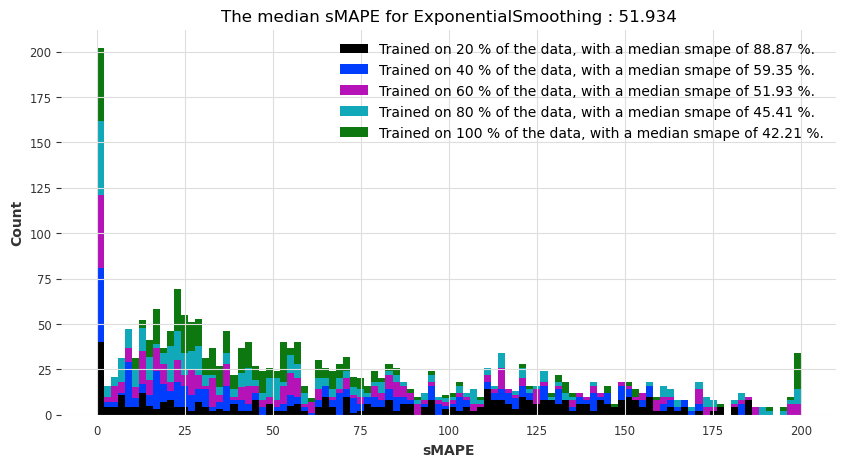

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

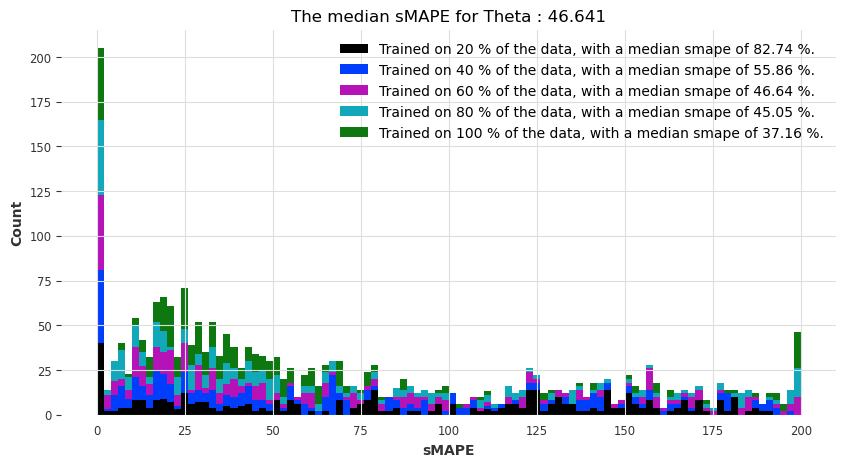

Visualization of performances taking the mean of the smapes over cross-validation


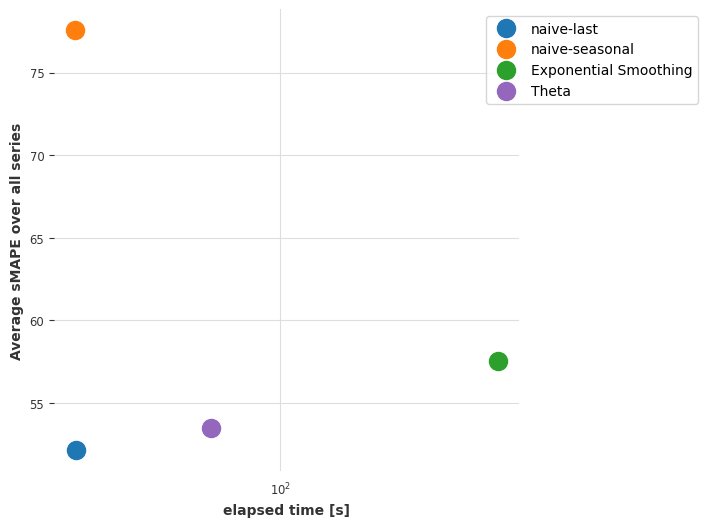

Visualization of performances taking the median of the smapes over cross-validation


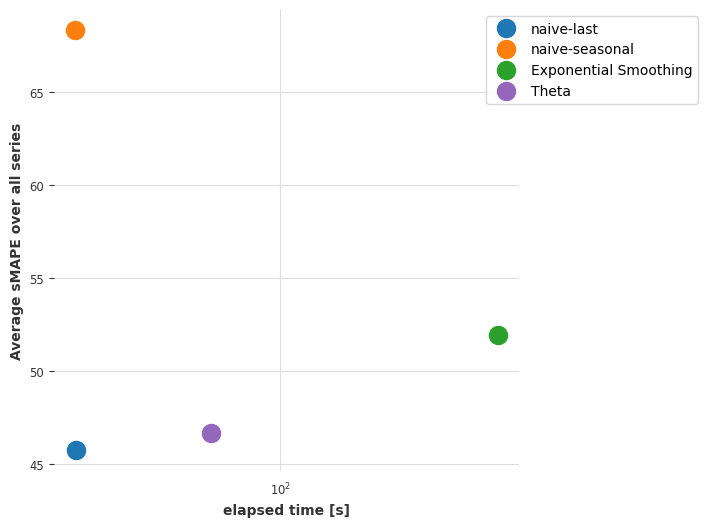

The results for index_colab_notincrem are:
The results for index_colab_notincrem with an horizon of 3 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

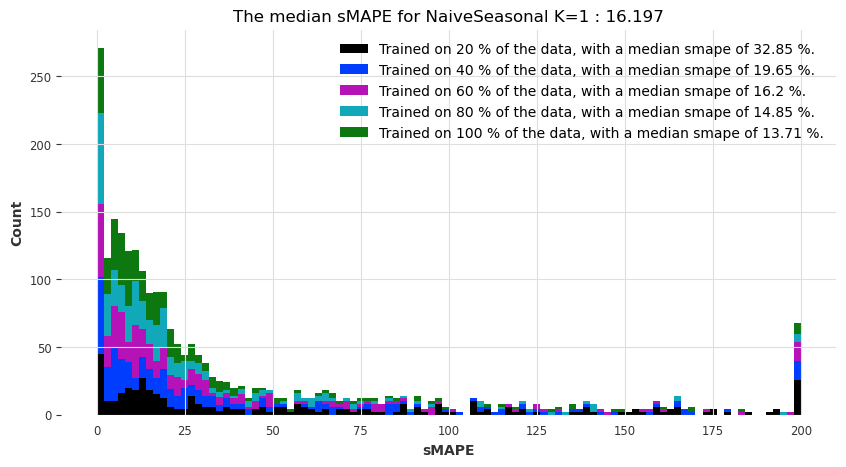

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

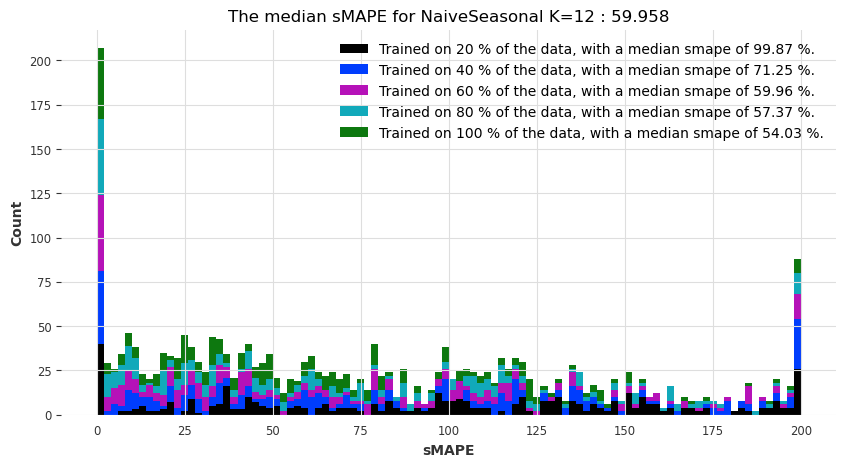

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

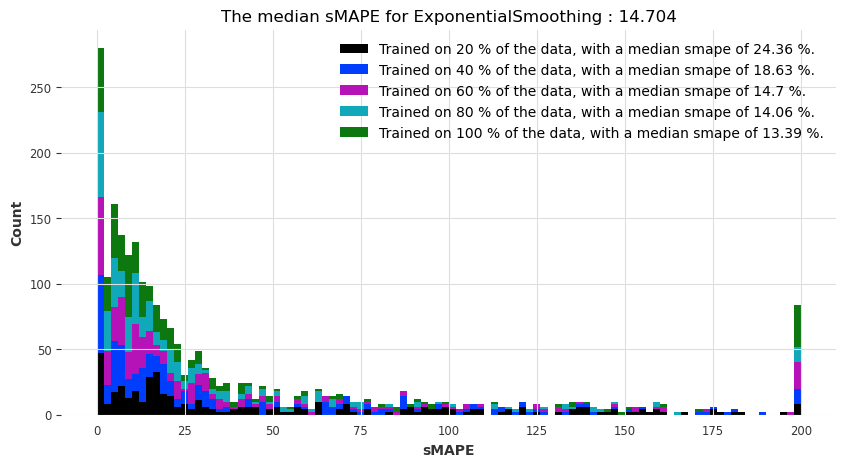

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

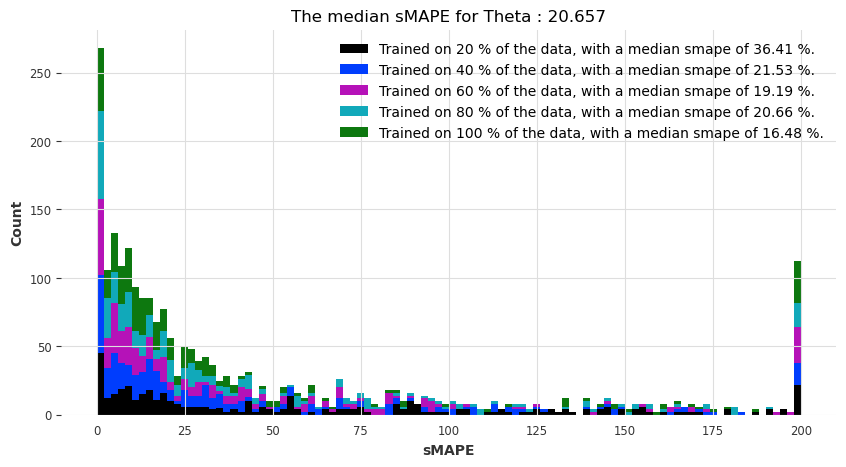

Visualization of performances taking the mean of the smapes over cross-validation


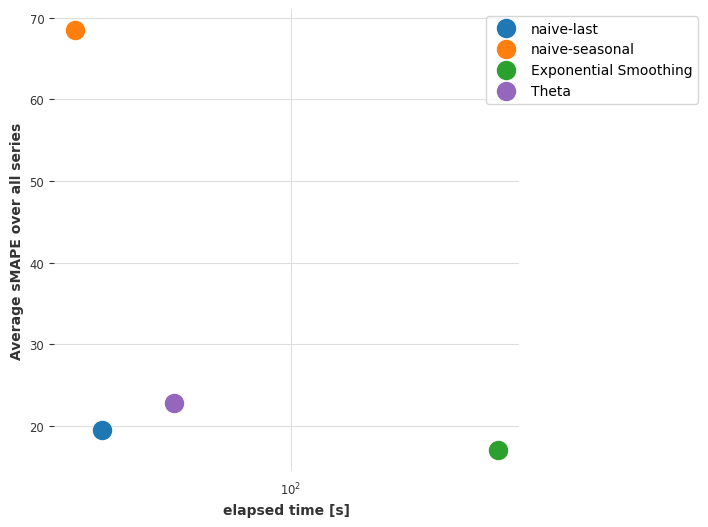

Visualization of performances taking the median of the smapes over cross-validation


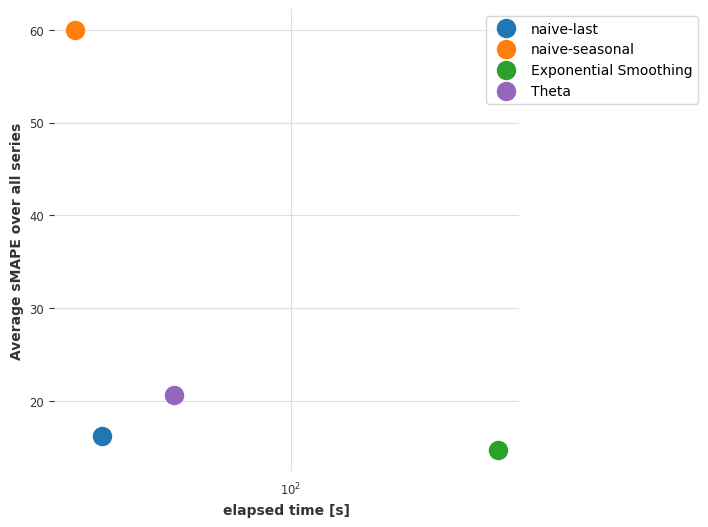

The results for index_colab_notincrem with an horizon of 6 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

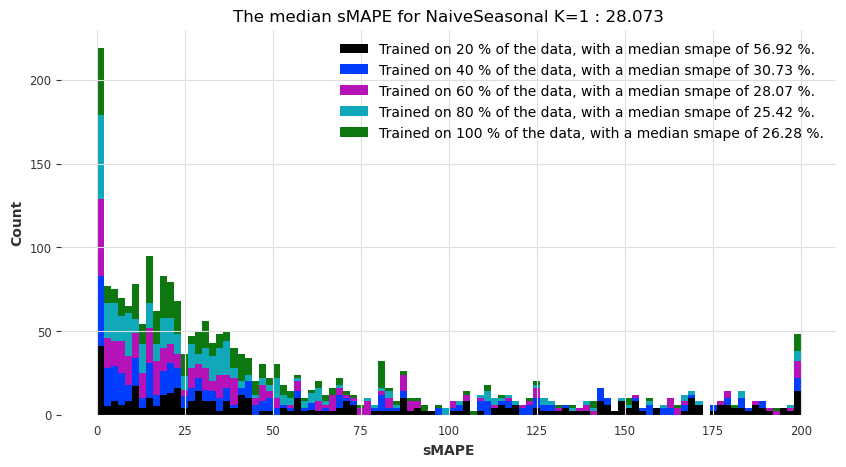

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

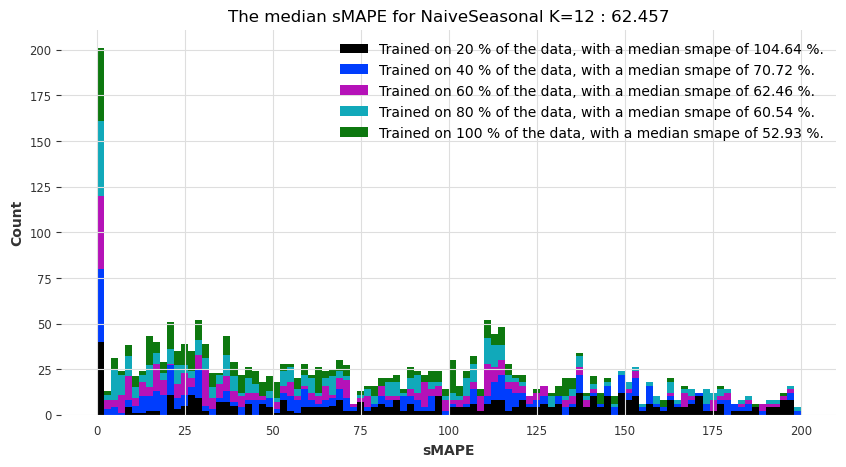

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

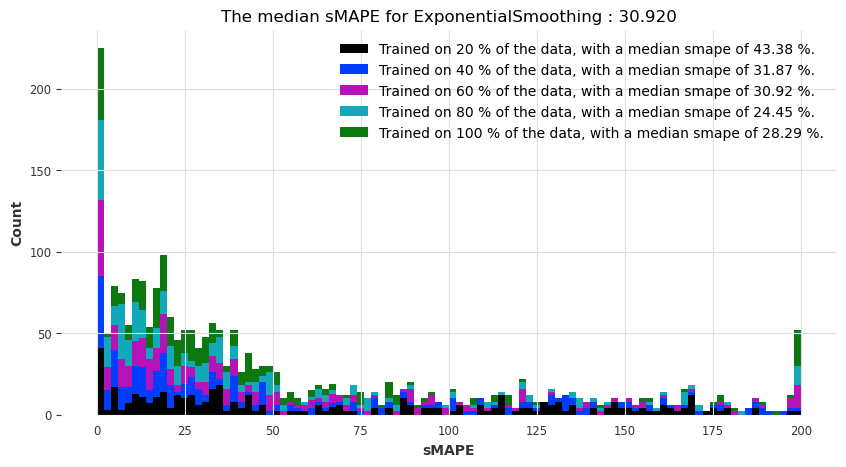

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

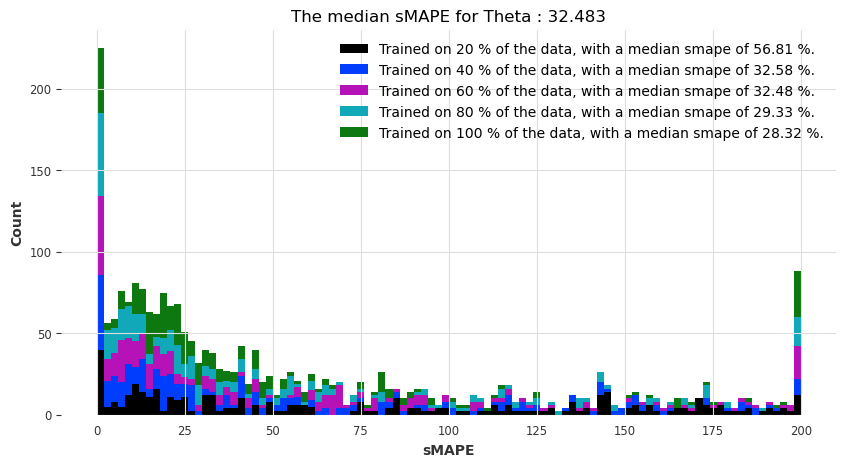

Visualization of performances taking the mean of the smapes over cross-validation


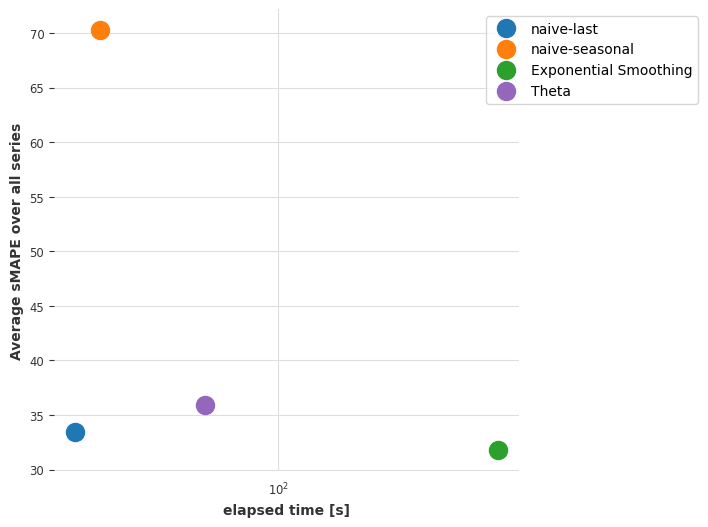

Visualization of performances taking the median of the smapes over cross-validation


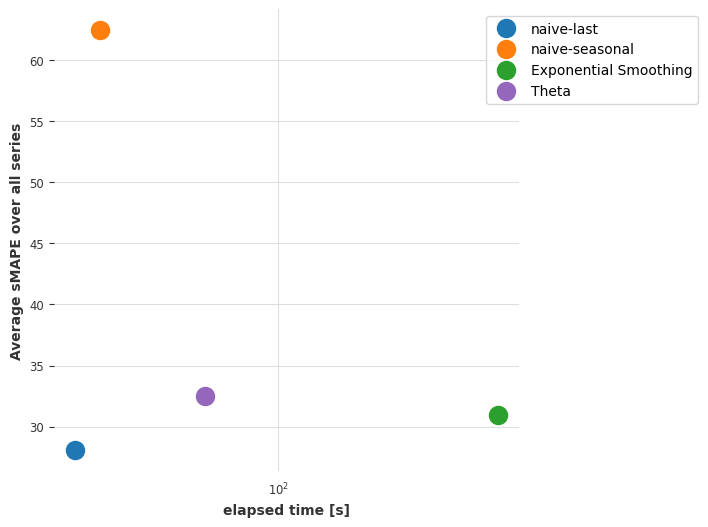

The results for index_colab_notincrem with an horizon of 12 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

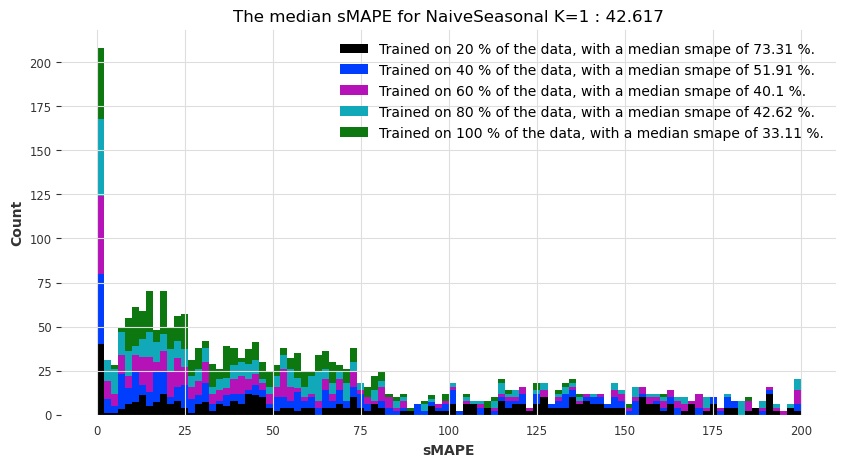

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

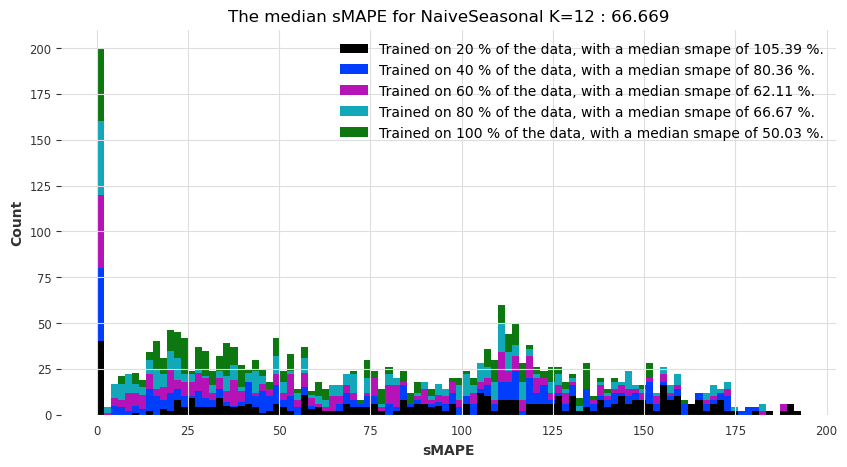

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

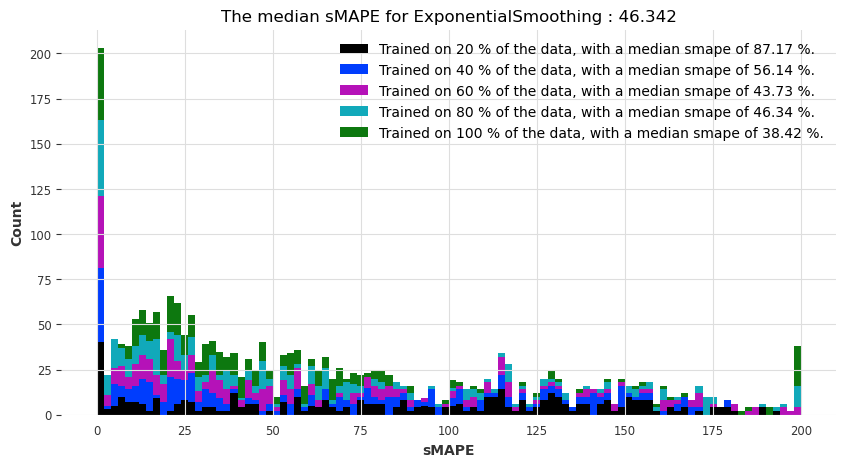

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

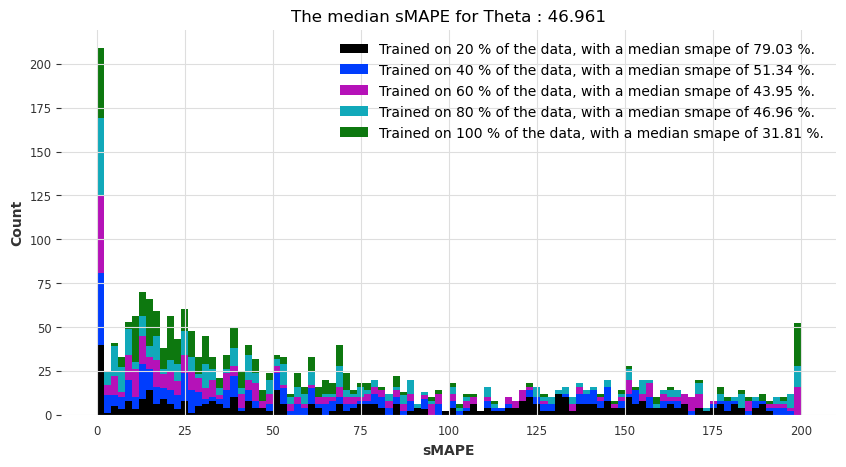

Visualization of performances taking the mean of the smapes over cross-validation


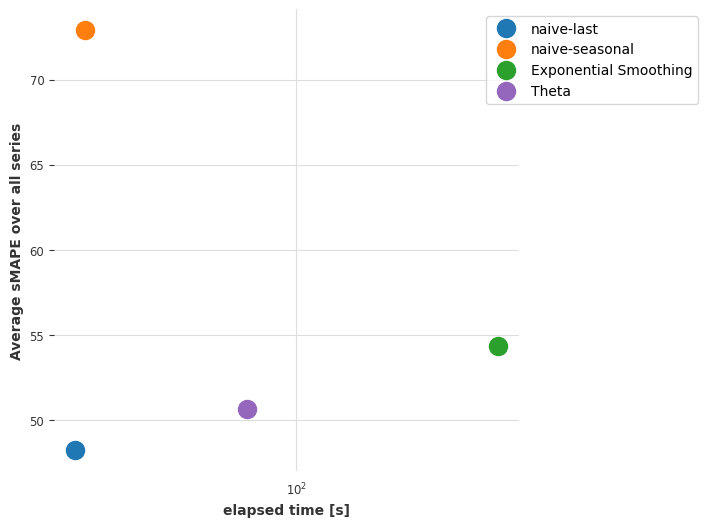

Visualization of performances taking the median of the smapes over cross-validation


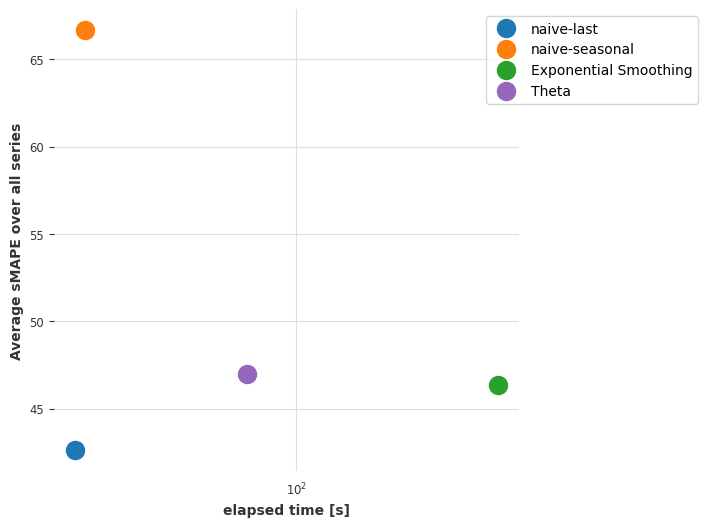

The results for index_keyword are:
The results for index_keyword with an horizon of 3 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

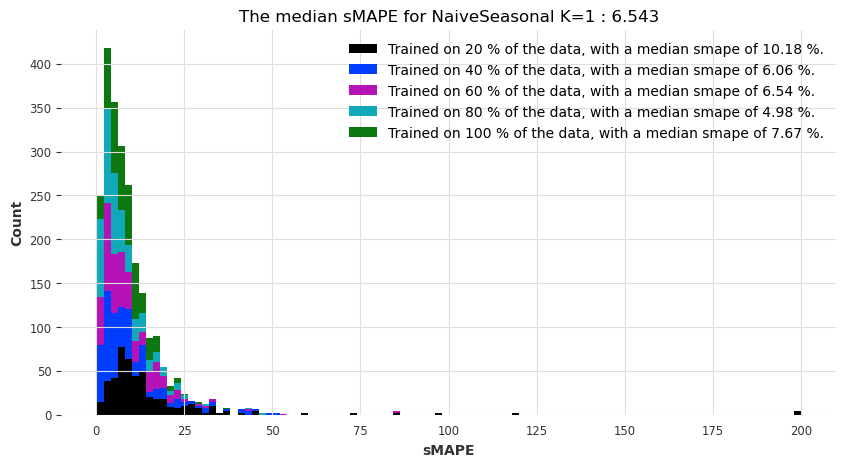

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

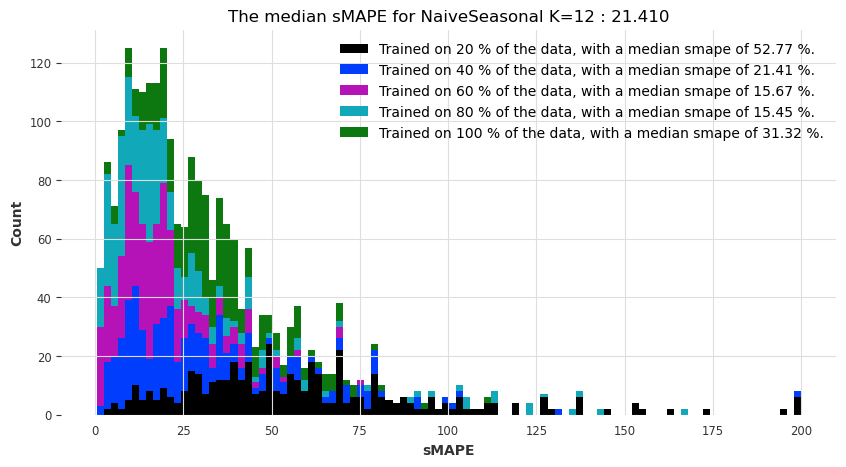

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

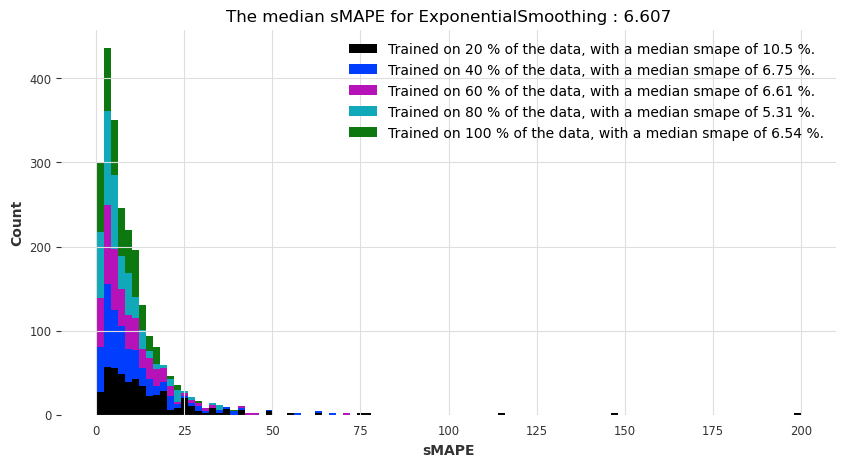

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

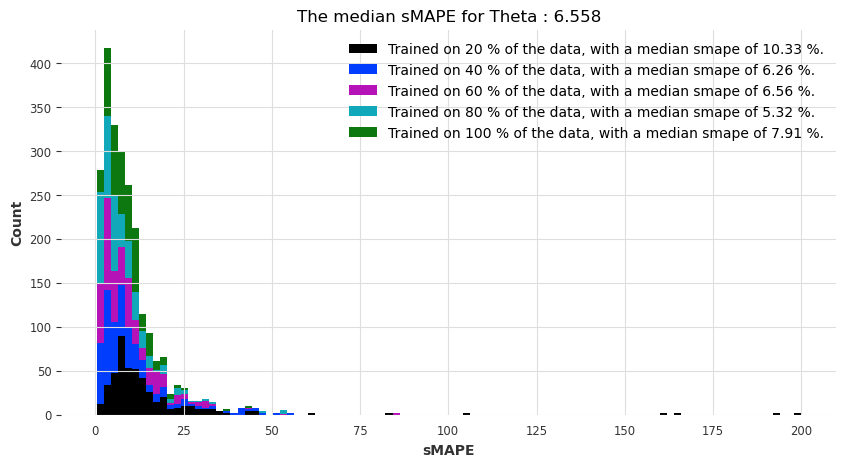

Visualization of performances taking the mean of the smapes over cross-validation


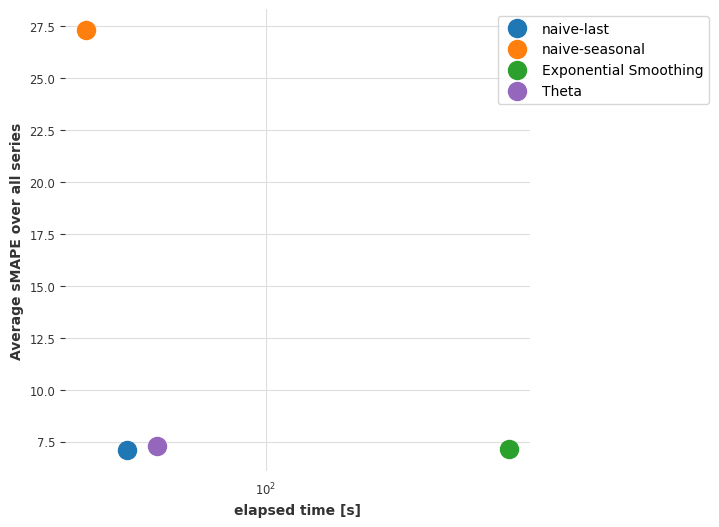

Visualization of performances taking the median of the smapes over cross-validation


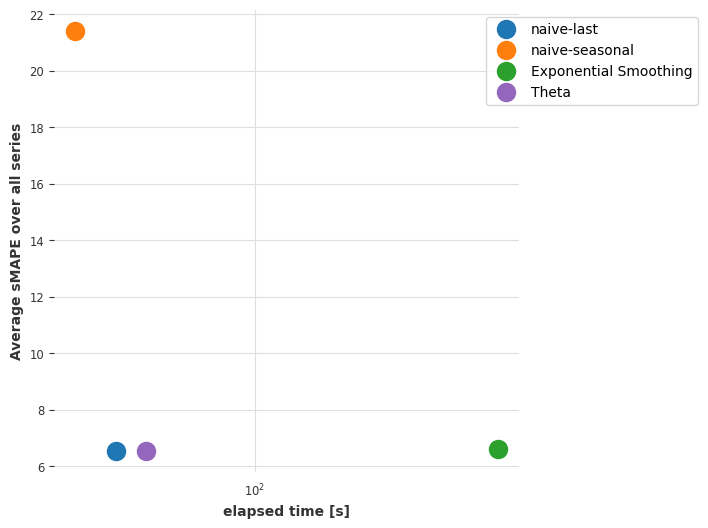

The results for index_keyword with an horizon of 6 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

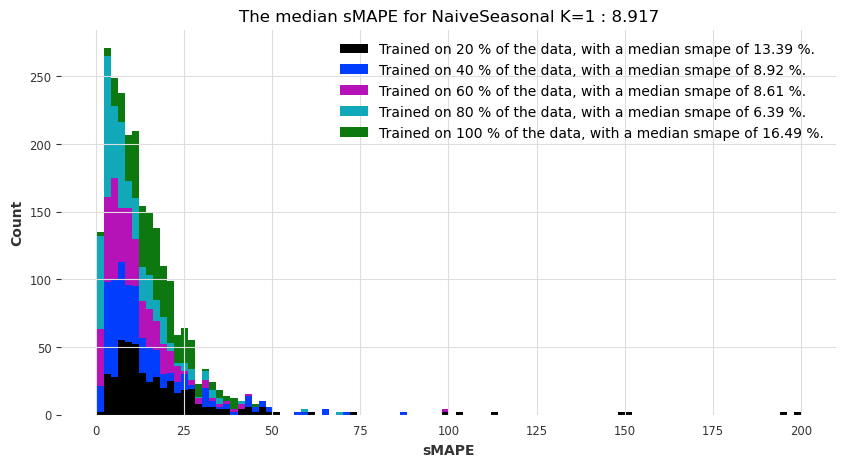

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

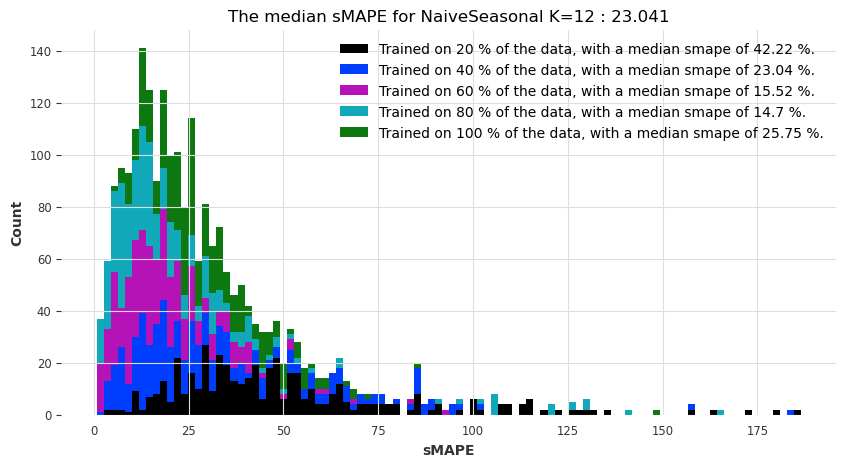

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

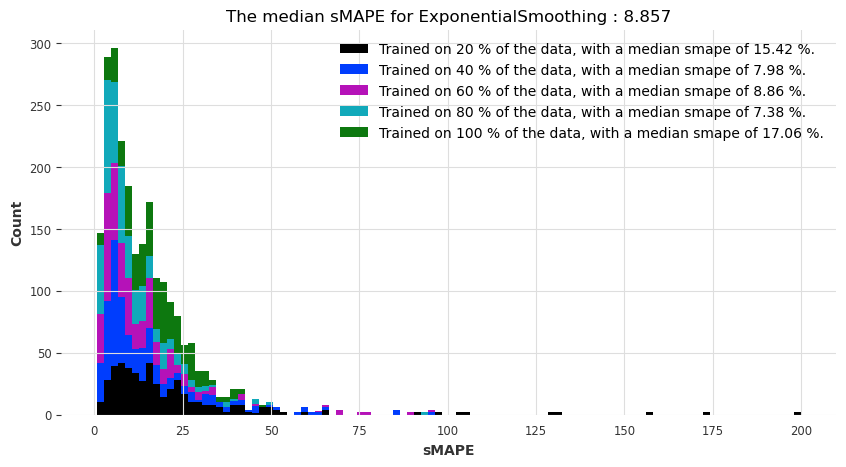

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

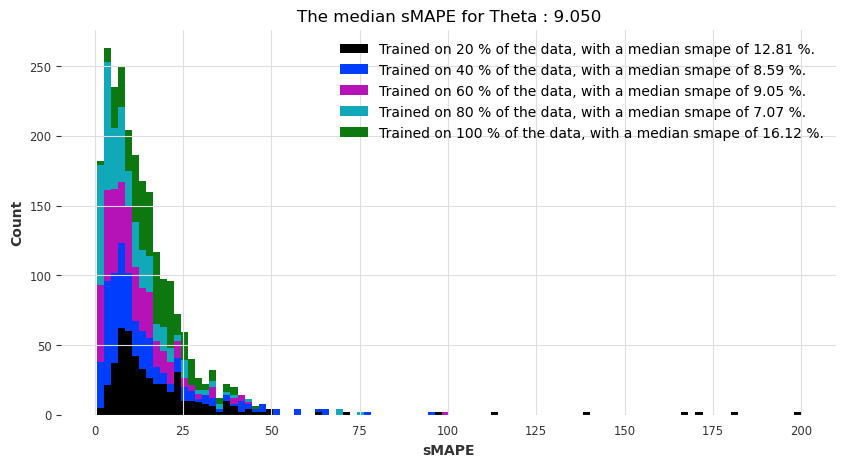

Visualization of performances taking the mean of the smapes over cross-validation


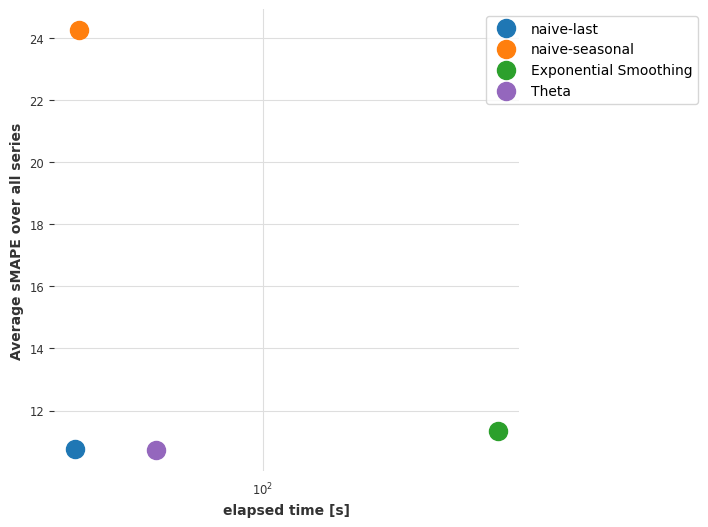

Visualization of performances taking the median of the smapes over cross-validation


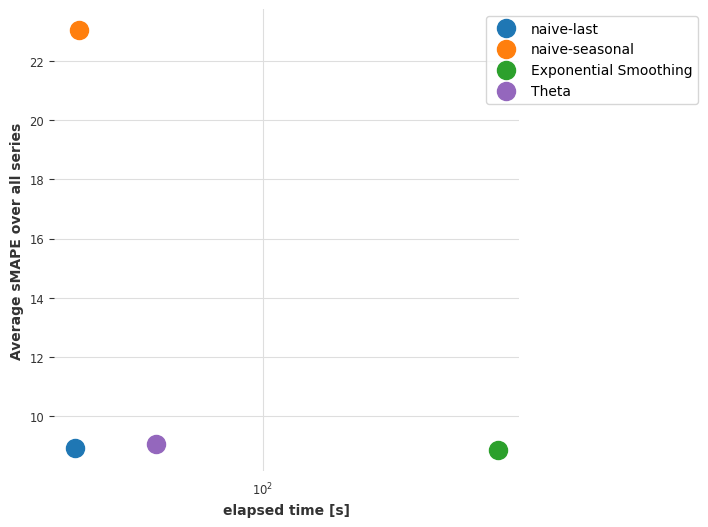

The results for index_keyword with an horizon of 12 are:


  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

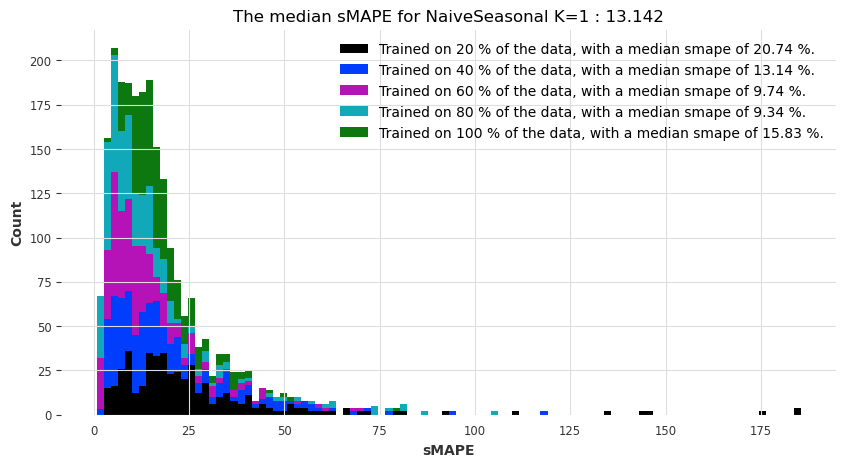

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

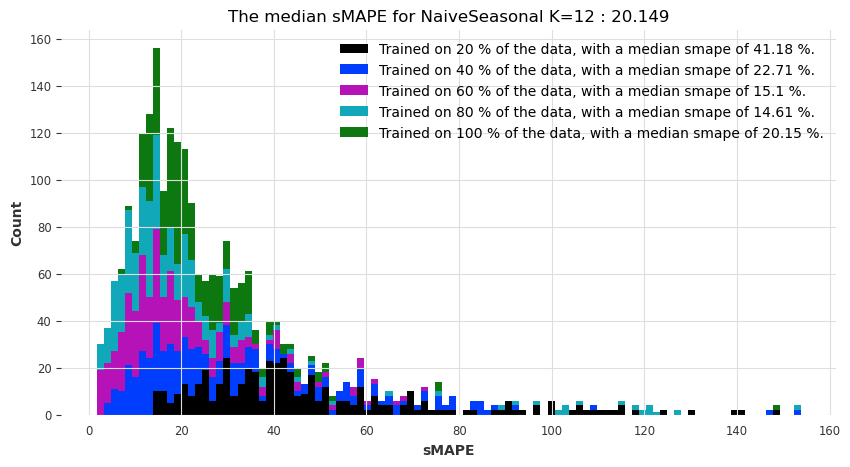

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

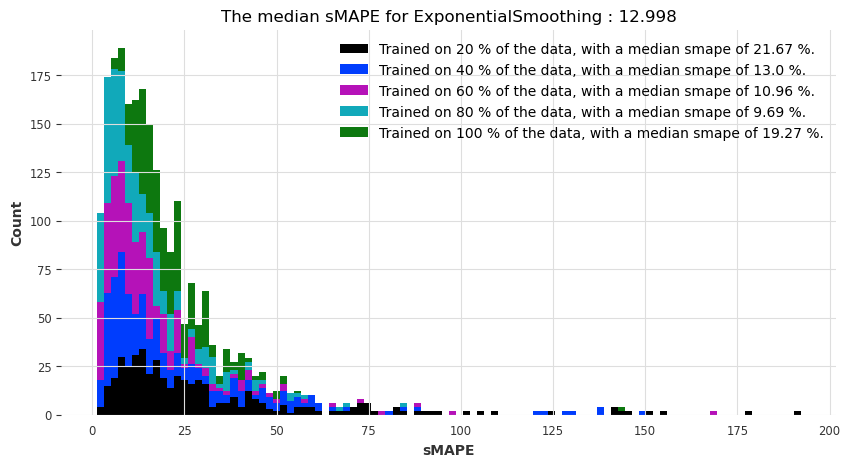

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

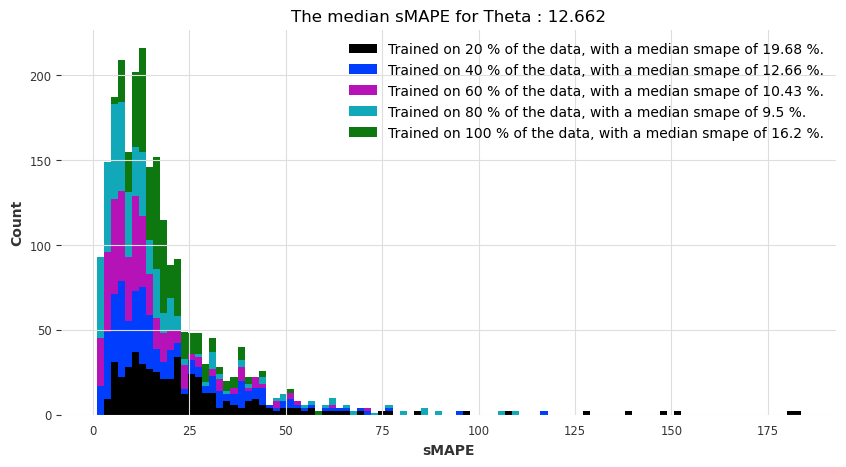

Visualization of performances taking the mean of the smapes over cross-validation


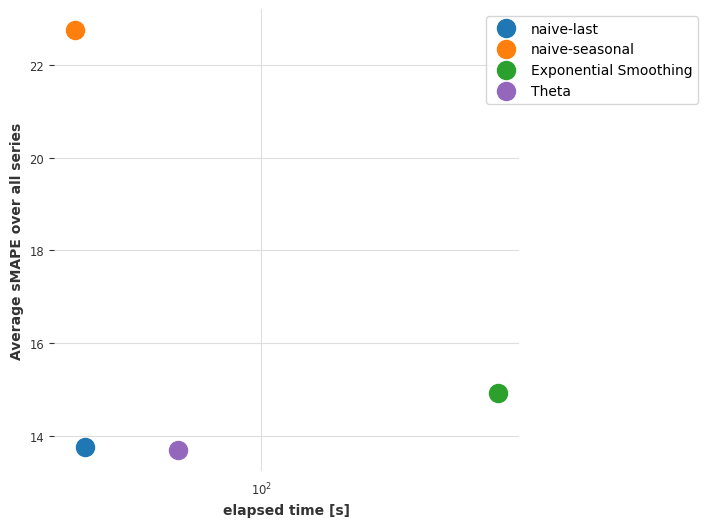

Visualization of performances taking the median of the smapes over cross-validation


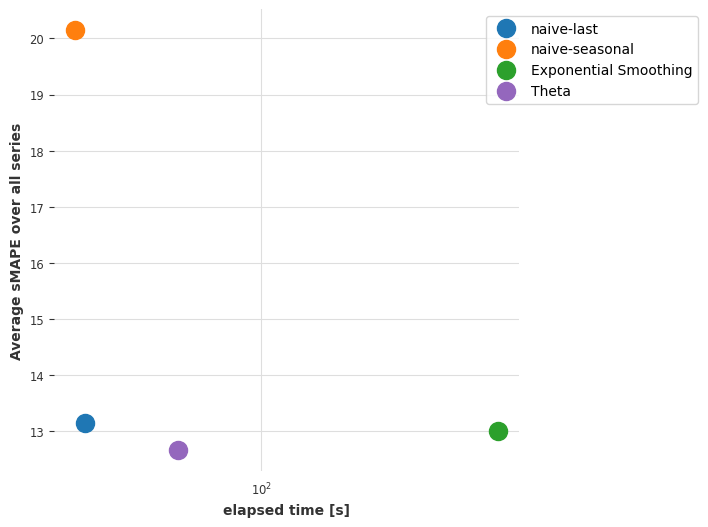

In [472]:
info_table = []
info_table_var=[]

for index in list_indices:
    dfofindex = dftm.loc[dftm['indextype']==index]
    print('The results for '+str(index)+' are:')
    listindex_byalgo=[]
    
    list_var_byalgo=[]
    
    for horizon in [3,6,12]:
        print('The results for '+str(index)+' with an horizon of '+str(horizon)+' are:')
        
        naive1_smapes_mean,naive12_smapes_mean,ets_smapes_mean,theta_smapes_mean,naive1_var_allerrors,naive1_mean_allvar,\
        naive12_var_allerrors,naive12_mean_allvar,ets_var_allerrors,ets_mean_allvar,theta_var_allerrors,theta_mean_allvar=\
        local_forecasting(dfofindex,horizon,list_concepts,5)
        
        listindex_byalgo =listindex_byalgo+\
        [naive1_smapes_mean,naive12_smapes_mean,ets_smapes_mean,theta_smapes_mean]
        
        list_var_byalgo=list_var_byalgo+[[naive1_var_allerrors,naive1_mean_allvar],[naive12_var_allerrors,naive12_mean_allvar]      
        ,[ets_var_allerrors,ets_mean_allvar],[theta_var_allerrors,theta_mean_allvar]]
        
    list_toappend=[]    
    for i in range(4):
        for j in range(3):
            list_toappend.append(listindex_byalgo[i+j*4])
    info_table.append(list_toappend)
    
    list_toappend_var=[]    
    for i in range(4):
        for j in range(3):
            list_toappend_var.append(list_var_byalgo[i+j*4])
    info_table_var.append(list(chain.from_iterable(list_toappend_var))) 

In [476]:
iterables = [["Naive seasonal (1)","Naive seasonal (12)", "Exponential smoothing","Theta"], ["3 months", "6 months","12 months"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon"])

df = pd.DataFrame({'Index citations t1-t2':info_table[0], 'Index citations t2-t1': info_table[1],
                   'Index colaboration incremental': info_table[2],'colaboration not incremental':info_table[3],
                   'Index keywords': info_table[4]}, index=index)
df

In [474]:
iterables = [["Naive seasonal (1)","Naive seasonal (12)", "Exponential smoothing","Theta"], ["3 months", "6 months","12 months"],["Mean of variances", "Variances over all errors"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon","Type of variance"])

df = pd.DataFrame({'Index citations t1-t2':info_table_var[0], 'Index citations t2-t1': info_table_var[1],
                   'Index colaboration incremental': info_table_var[2],'colaboration not incremental':info_table_var[3],
                   'Index keywords': info_table_var[4]}, index=index)
df

Index citations t1-t2  \
Forecaster algorithm  Forecasting horizon Type of variance                                   
Naive seasonal (1)    3 months            Mean of variances                       1.084828   
                                          Variances over all errors               0.018311   
                      6 months            Mean of variances                       3.550107   
                                          Variances over all errors               0.171189   
                      12 months           Mean of variances                      11.936950   
                                          Variances over all errors               0.739374   
Naive seasonal (12)   3 months            Mean of variances                      32.645734   
                                          Variances over all errors               0.037006   
                      6 months            Mean of variances                      22.159658   
                                          Variances over all errors               0.422096   
                      12 months           Mean of variances                      18.175779   
                                          Variances over all errors               0.658760   
Exponential smoothing 3 months            Mean of variances                       0.382825   
                                          Variances over all errors               0.027356   
                      6 months            Mean of variances                       1.033080   
                                          Variances over all errors               0.080089   
                      12 months           Mean of variances                      37.356652   
                                          Variances over all errors               1.941509   
Theta                 3 months            Mean of variances                       1.131367   
                                          Variances over all errors               0.018802   
                      6 months            Mean of variances                       3.690556   
                                          Variances over all errors               0.176937   
                      12 months           Mean of variances                      12.321973   
                                          Variances over all errors               0.753877   

                                                                     Index citations t2-t1  \
Forecaster algorithm  Forecasting horizon Type of variance                                   
Naive seasonal (1)    3 months            Mean of variances                       1.084828   
                                          Variances over all errors               0.018311   
                      6 months            Mean of variances                       3.550107   
                                          Variances over all errors               0.171189   
                      12 months           Mean of variances                      11.936950   
                                          Variances over all errors               0.739374   
Naive seasonal (12)   3 months            Mean of variances                      32.645734   
                                          Variances over all errors               0.037006   
                      6 months            Mean of variances                      22.159658   
                                          Variances over all errors               0.422096   
                      12 months           Mean of variances                      18.175779   
                                          Variances over all errors               0.658760   
Exponential smoothing 3 months            Mean of variances                       0.382825   
                                          Variances over all errors               0.027356   
                      6 months            Mean of variances                       1.033080   
                          

The naive model with K=1 is the one which perform the best. This is probably due to the fact, that a very high percent of time series (~25%) are flat and therefore predicting the last values is very accurate if not completely exact in these cases. Besides, the time series are very chaotic. For this reason, even if the other forecasting algorithms might model the overall tendency of the time series, they fail to be very accurate and this results in big errors. Nevertheless, the exponential algorithm performs almost as well as the naive K=1 model.

# **Part 2 -- Global forecasting based on clustering**

We now do global forecasting on our time series using the clustering I created.

<div class="alert-info">
2.1. Randomized clustering of the time series.
</div>

To see whether the clustering makes sense to forecasting we will attribute randomly each sample to the same number of clusters as present in the algorithm, do the forecasting and compare the results. We should keep in mind, that there are 1+numbercluster number of clusters, since I created artifically a cluster with all the time series that are very flat.

In [ ]:
def clustering_df_rand(dftm,list_concepts,numbercluster):

    # creating a randomized clustering
    
    listcluster_rand=[]

    for concept1 in list_concepts:
        dfinter1=df_interpolation.loc[df_interpolation['concept1']==concept1]
        for concept2 in list_concepts:
            dfinter2=dfinter1.loc[dfinter1['concept2']==concept2]
            interpolation_score = dfinter2.interpolation_ratio.tolist()[0]
            for index in list_indices:
                if interpolation_score<0.5:
                    cluster_numbering= random.randint(1, numbercluster)
                    listcluster_rand.append(cluster_numbering)
    
    #Creating the dataframe with randomized cluster.
    dftm_rand=dftm.copy()
    dftm_rand['cluster']=listcluster_rand
    
    return dftm_rand

<div class="alert-info">
2.2. Forecasting and comparing the results between the randomized and algorithmic clustering
</div>

Comparing the different forecasting algorithms.

In [ ]:
def eval_kcross_forecasts_cluster(smapes,modelname,addinfo):
    
    plt.figure(figsize=(10, 5))
    
    themedians = []
    labels = []
    
    for i in range(len(smapes)):
        themedians.append(np.median(smapes[i]))
        #plt.hist(smapes[i], bins=100,label='K-cross set'+str(i+1))
        labels = labels +['Trained and forecasted on the cluster '+str(i)+\
        ' , with a median smape of '+ str(round(np.median(smapes[i]),2))+' %.']
        
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("The median sMAPE for "+str(modelname)+' '+str(addinfo)+" : %.3f" % np.median(themedians))
    #plt.yscale('log')

    
    plt.hist(smapes,bins=100,histtype='barstacked',label=labels)
    
    plt.legend()
    plt.show()
    plt.close()

In [ ]:
def cross_validation_splitting_window_global_clustering(data,horizon,list_concepts,number_cv,modelname,forecaster,**kwargs):
    
    time1=time.time()
    
    maximal_train_len = 252-horizon
    score_forecaster = []
    allsmapes=[]
    
    mean_allvar= []
    var_alltheerrors = []
    
    for i in range(number_cv):
        if i<number_cv-1:
            windowslength =maximal_train_len//number_cv
            startingtime = i*windowslength
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        else:
            windowslength = maximal_train_len-(number_cv-1)*(maximal_train_len//number_cv) # to get the remaining window
            startingtime = i*(maximal_train_len//number_cv)
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
        
        allsmapes.append(smapes)
        score_forecaster.append(np.median(smapes))
        # I save the mean of the all the smapes done over one window
                
        var_alltheerrors.append(var_allerrors)
        mean_allvar.append(var_mean_var)
        
    myscores =np.array(score_forecaster)
    
    time2=time.time()
    elapsed_time = time2-time1
    
    
    return elapsed_time,np.mean(myscores),np.median(myscores),allsmapes,np.mean(var_allerrors),np.mean(mean_allvar)

In [ ]:
def cross_validation_expanding_window_global_clustering(data,horizon,list_concepts,number_cv,modelname,forecaster,**kwargs):
    
    time1=time.time()
    
    startingtime=0
    maximal_train_len = 252-horizon
    score_forecaster = []
    allsmapes=[]
    
    mean_allvar= []
    var_alltheerrors = []
    
    for i in range(number_cv):
        if i<number_cv-1:
            windowslength =(i+1)*(maximal_train_len//number_cv)
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
            
        else:
            windowslength = maximal_train_len
            df = creating_train_test_tm(data,startingtime,windowslength,horizon,list_concepts)
            smapes,var_allerrors,var_mean_var\
            =eval_global_model(df['Train tm'].tolist(),df['Test tm'].tolist(),horizon,forecaster,**kwargs)
        
        allsmapes.append(smapes)
        score_forecaster.append(np.median(smapes))
        # I save the mean of the all the smapes done over one window
        
        var_alltheerrors.append(var_allerrors)
        mean_allvar.append(var_mean_var)

    myscores =np.array(score_forecaster)
    
    time2=time.time()
    elapsed_time = time2-time1
    
    plt.plot()

    return elapsed_time,np.mean(myscores),np.median(myscores),allsmapes,np.mean(var_allerrors),np.mean(mean_allvar)

In [ ]:
def cluster_computation(dftm, dftm_rand,horizon,numbercluster,list_concepts,number_cv,modelname,forecaster,**kwargs):
    
    elapsed_time_rand=[]
    error_rand_mean=[]
    error_rand_med=[]
    var_allerrors_rand = []
    mean_allvar_rand =[]
    
    allsmapes_rand = []
    # once I created my dataframe with this specific horizon I train and visualize the results of the forecasting algorithms

    print('Randomized clustering')
    for i in tqdm(range(1,numbercluster+1)):

        mydf_rand= dftm_rand.loc[dftm_rand['cluster']==int(i)]
        
        time_rand, smapes_rand_mean,smapes_rand_med,smapes_rand,var_allerrors_rand_number,mean_allvar_rand_number =\
        cross_validation_expanding_window_global_clustering(mydf_rand,\
        horizon,list_concepts,number_cv,modelname,forecaster,**kwargs)

        elapsed_time_rand.append(time_rand)
        error_rand_mean.append(smapes_rand_mean)
        error_rand_med.append(smapes_rand_med)
        allsmapes_rand.append(list(chain.from_iterable(smapes_rand)))
        
        var_allerrors_rand.append(var_allerrors_rand_number)
        mean_allvar_rand.append(mean_allvar_rand_number)

    
    eval_kcross_forecasts_cluster(allsmapes_rand,modelname,'randomized')
    
        
    elapsed_time=[]
    error_mean=[]
    error_med=[]
    var_allerrors = []
    mean_allvar =[]
    
    allsmapes = []
    
    print('Algorithmic clustering based on similarity')
    for i in tqdm(range(1,numbercluster+1)):     

        mydf= dftm.loc[dftm['cluster']==int(i)]
        
        time_normal, smapes_mean,smapes_med,smapes_normal,var_allerrors_number,mean_allvar_number =\
        cross_validation_expanding_window_global_clustering(mydf,\
        horizon,list_concepts,number_cv,modelname,forecaster,**kwargs)
        
        elapsed_time.append(time_normal)
        error_mean.append(smapes_mean)
        error_med.append(smapes_med)
        allsmapes.append(list(chain.from_iterable(smapes_normal)))
          
        var_allerrors.append(var_allerrors_number)
        mean_allvar.append(mean_allvar_number)
    
    eval_kcross_forecasts_cluster(allsmapes,modelname,'not-randomized')
    
    smapes_rand = np.mean(error_rand_mean)
    time_rand = np.mean(elapsed_time_rand)
    smapes = np.mean(error_mean)
    time = np.mean(elapsed_time)
    
    return smapes_rand,time_rand,smapes,time,np.mean(var_allerrors_rand),np.mean(mean_allvar_rand),np.mean(var_allerrors),np.mean(mean_allvar) 

In [ ]:
def clustering_forecasting(dftm,dftm_rand,horizon,numbercluster,list_concepts,number_cv):
    mylag =252//number_cv-2*horizon
    # number of datapoints considered to forecast
    # I substracted -3, because I was having problems with the authorized lags in the function  

    print(' ')
    
    lr_smapes_rand,lr_time_rand,lr_smapes,lr_time,\
    lr_var_allerrors_rand,lr_mean_allvar_rand,lr_var_allerrors,lr_mean_allvar\
    = cluster_computation(dftm, dftm_rand,horizon,numbercluster,\
    list_concepts,number_cv,'LinearRegressionModel',LinearRegressionModel, lags=mylag, output_chunk_length=horizon)
        
    print(' ')
        
    lgbm_smapes_rand,lgbm_time_rand,lgbm_smapes,lgbm_time,\
    lgbm_var_allerrors_rand,lgbm_mean_allvar_rand,lgbm_var_allerrors,lgbm_mean_allvar\
    = cluster_computation(dftm, dftm_rand,horizon,numbercluster,\
    list_concepts,number_cv,'LightGBMModel',LightGBMModel, lags=mylag, output_chunk_length=horizon, objective="mape")
    
    print(' ')
    
    rf_smapes_rand,rf_time_rand,rf_smapes,rf_time, \
    rf_var_allerrors_rand,rf_mean_allvar_rand,rf_var_allerrors,rf_mean_allvar\
    = cluster_computation(dftm, dftm_rand,horizon,numbercluster,\
    list_concepts,number_cv,'RandomForest',RandomForest,lags=mylag, output_chunk_length=horizon)
    
    print(' ')
    
    nbeat_smapes_rand,nbeat_time_rand,nbeat_smapes,nbeat_time,\
    nbeat_var_allerrors_rand,nbeat_mean_allvar_rand,nbeat_var_allerrors,nbeat_mean_allvar\
    = cluster_computation(dftm, dftm_rand,horizon,numbercluster,\
    list_concepts,number_cv,'NBEATSModel',NBEATSModel,input_chunk_length=mylag,output_chunk_length=horizon,num_stacks=20,
    num_blocks=1,num_layers=2,layer_widths=136,expansion_coefficient_dim=11,loss_fn=SmapeLoss(),batch_size=1024,
    optimizer_kwargs={"lr":  1e-3})
    
    # visualization of the results 

    
    smapes_2 = {
        "Linear Regression": lr_smapes,
        "LGBM": lgbm_smapes,
        "Random Forest": rf_smapes,
        "NBeats": nbeat_smapes,
        
        "Linear Regression_rand": lr_smapes_rand,
        "LGBM_rand": lgbm_smapes_rand,
        "Random Forest_rand": rf_smapes_rand,
        "NBeats_rand": nbeat_smapes_rand,
    }

    elapsed_times_2 = {
        "Linear Regression": lr_time,
        "LGBM": lgbm_time,
        "Random Forest": rf_time,
        "NBeats": nbeat_time,
        
        "Linear Regression_rand": lr_time_rand,
        "LGBM_rand": lgbm_time_rand,
        "Random Forest_rand": rf_time_rand,
        "NBeats_rand": nbeat_time_rand,
    }

    plot_models_cluster(elapsed_times_2, smapes_2)
    
    list_var_error = [[nbeat_var_allerrors_rand,nbeat_mean_allvar_rand,nbeat_var_allerrors,nbeat_mean_allvar],
            [rf_var_allerrors_rand,rf_mean_allvar_rand,rf_var_allerrors,rf_mean_allvar],
            [lgbm_var_allerrors_rand,lgbm_mean_allvar_rand,lgbm_var_allerrors,lgbm_mean_allvar],
            [lr_var_allerrors_rand,lr_mean_allvar_rand,lr_var_allerrors,lr_mean_allvar]]
    
    return lr_smapes,lgbm_smapes,rf_smapes,nbeat_smapes,lr_smapes_rand,lgbm_smapes_rand,rf_smapes_rand,nbeat_smapes_rand,list_var_error

In [ ]:
numbercluster = max(dftm.cluster.tolist())
numbercluster

In [ ]:
dftm_rand=clustering_df_rand(dftm,list_concepts,numbercluster)

We just do without cross-validation, because with cross validation it is way to long. At least this can give us a reasonable idea of the performance of clustering forecasting.

In [ ]:
info_table = []

info_table_var = []

for index in list_indices:
    dfofindex = dftm.loc[dftm['indextype']==index]
    print('The results for '+str(index)+' are:')
    listindex_byalgo=[]
    dfofindex_rand = dftm_rand.loc[dftm_rand['indextype']==index]
    
    listvar_byalgo =[]
    
    for horizon in [3]:
        print('The results for '+str(index)+' with an horizon of '+str(horizon)+' are:')
        lr_smapes,lgbm_smapes,rf_smapes,nbeat_smapes,lr_smapes_rand,lgbm_smapes_rand,rf_smapes_rand,nbeat_smapes_rand,\
        list_var_error=clustering_forecasting(dfofindex,dfofindex_rand,horizon,numbercluster,list_concepts,1)
        
        listindex_byalgo=listindex_byalgo+\
        [lr_smapes,lgbm_smapes,rf_smapes,nbeat_smapes,lr_smapes_rand,lgbm_smapes_rand,\
        rf_smapes_rand,nbeat_smapes_rand]
        
        listvar_byalgo = listvar_byalgo+list_var_error
    
    list_toappend=[]    
    for i in range(8):
        for j in range(3):
            list_toappend.append(listindex_byalgo[i+j*8])
    info_table.append(list_toappend)
    
    list_toappend_var=[]    
    for i in range(4):
        for j in range(3):
            list_toappend_var.append(listvar_byalgo[i+j*4])
    info_table_var.append(list(chain.from_iterable(list_toappend_var)))

not randomized clustering

In [ ]:
iterables = [["Linear Regression","LGBM", "Random Forest","NBeats"], ["3 months", "6 months","12 months"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon"])

df = pd.DataFrame({'Index citations t1-t2':info_table[0][:12], 'Index citations t2-t1': info_table[1][:12],
                   'Index colaboration incremental': info_table[2][:12],'colaboration not incremental':info_table[3][:12],
                   'Index keywords': info_table[4][:12]}, index=index)
df

randomized clustering

In [ ]:
iterables = [["Linear Regression","LGBM", "Random Forest","NBeats"], ["3 months", "6 months","12 months"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon"])

df = pd.DataFrame({'Index citations t1-t2':info_table[0][12:], 'Index citations t2-t1': info_table[1][12:],
                   'Index colaboration incremental': info_table[2][12:],'colaboration not incremental':info_table[3][12:],
                   'Index keywords': info_table[4][12:]}, index=index)
df

In [ ]:
iterables = [["Linear Regression","LGBM", "Random Forest","NBeats"], ["3 months", "6 months","12 months"],["Randomized","Not-randomized"],["Mean of variances", "Variances over all errors"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon","Randomization","Type of variance"])

df = pd.DataFrame({'Index citations t1-t2':info_table_var[0], 'Index citations t2-t1': info_table_var[1],
                   'Index colaboration incremental': info_table_var[2],'colaboration not incremental':info_table_var[3],
                   'Index keywords': info_table_var[4]}, index=index)
df

As a conclusion, we observe that Nbeats and Random forest are the best forecasting algorithms in the setting of clusters forecasting. For a horizon 3 and 6, random forest is better while for a horizon 12, nbeats is slightly better than random forest.

# **Part 3 -- Global forecasting based on my own data**

This takes 12 hours to run.

In [ ]:
def global_forecasting_mydata(dftm,horizon,list_concepts,number_cv):

    mylag =252//number_cv-2*horizon

    # regression models
            
    lr_time, lr_smapes_mean,lr_smapes_med,lr_var_allerrors,lr_mean_allvar =\
    cross_validation_expanding_window_global(dftm,\
    horizon,list_concepts,number_cv,'LinearRegressionModel', LinearRegressionModel, lags=mylag, output_chunk_length=horizon)
    
    lgbm_time, lgbm_smapes_mean,lgbm_smapes_med,lgbm_var_allerrors,lgbm_mean_allvar =\
    cross_validation_expanding_window_global(dftm,\
    horizon,list_concepts,number_cv,'LightGBMModel', LightGBMModel,lags=mylag, output_chunk_length=horizon, objective="mape")
  
    rf_time, rf_smapes_mean,rf_smapes_med,rf_var_allerrors,rf_mean_allvar\
    =cross_validation_expanding_window_global(dftm,\
    horizon,list_concepts,number_cv,'RandomForest', RandomForest,lags=mylag, output_chunk_length=horizon)
    
    #deep learning models

    nbeat_time,nbeat_smapes_mean,nbeat_smapes_med,nbeat_var_allerrors,nbeat_mean_allvar\
    =cross_validation_expanding_window_global(dftm,\
    horizon,list_concepts,number_cv,'NBEATSModel', NBEATSModel,input_chunk_length=mylag,output_chunk_length=horizon,num_stacks=20,
    num_blocks=1,num_layers=2,layer_widths=136,expansion_coefficient_dim=11,loss_fn=SmapeLoss(),batch_size=1024,
    optimizer_kwargs={"lr":  1e-3})
    
    smapes_mean = {
        "Linear Regression": lr_smapes_mean,
        "LGBM": lgbm_smapes_mean,
        "Random Forest": rf_smapes_mean,
        "NBeats": nbeat_smapes_mean,
    }

    elapsed_times = {
        "Linear Regression": lr_time,
        "LGBM": lgbm_time,
        "Random Forest": rf_time,
        "NBeats": nbeat_time,
    }

    smapes_med = {
        "Linear Regression": lr_smapes_med,
        "LGBM": lgbm_smapes_med,
        "Random Forest": rf_smapes_med,
        "NBeats": nbeat_smapes_med,
    }


        
    print('Visualization of performances taking the mean of the smapes over cross-validation')
    plot_models(elapsed_times, smapes_mean)
    
        
    print('Visualization of performances taking the median of the smapes over cross-validation')
    plot_models(elapsed_times, smapes_med)
    
    return lr_smapes_mean,lgbm_smapes_mean,rf_smapes_mean,nbeat_smapes_mean,
    lr_var_allerrors,lr_mean_allvar,lgbm_var_allerrors,lgbm_mean_allvar,
    rf_var_allerrors,rf_mean_allvar,nbeat_var_allerrors,nbeat_mean_allvar

In [ ]:
info_table = []
info_table_var=[]

for index in list_indices:
    dfofindex = dftm.loc[dftm['indextype']==index]
    print('The results for '+str(index)+' are:')
    listindex_byalgo=[]

    list_var_byalgo=[]
    
    for horizon in [3,6,12]:
        print('The results for '+str(index)+' with an horizon of '+str(horizon)+' are:')
        lr_smapes_mean,lgbm_smapes_mean,rf_smapes_mean,nbeats_smapes_mean,\
        lr_var_allerrors,lr_mean_allvar,lgbm_var_allerrors,lgbm_mean_allvar,\
        rf_var_allerrors,rf_mean_allvar,nbeat_var_allerrors,nbeat_mean_allvar=\
        global_forecasting_mydata(dfofindex,horizon,list_concepts,5)
        
        listindex_byalgo=listindex_byalgo+\
        [lr_smapes_mean,lgbm_smapes_mean,rf_smapes_mean,nbeats_smapes_mean]
        
        list_var_byalgo=list_var_byalgo+[[lr_var_allerrors,lr_mean_allvar],[lgbm_var_allerrors,lgbm_mean_allvar],
        [rf_var_allerrors,rf_mean_allvar],[nbeat_var_allerrors,nbeat_mean_allvar]]
    
    list_toappend=[]    
    for i in range(4):
        for j in range(3):
            list_toappend.append(listindex_byalgo[i+j*4])
    info_table.append(list_toappend)
    
    list_toappend_var=[]    
    for i in range(4):
        for j in range(3):
            list_toappend_var.append(list_var_byalgo[i+j*4])
    info_table_var.append(list(chain.from_iterable(list_toappend_var)))

Global forecasting table of results.

In [ ]:
iterables = [["Linear Regression","LGBM", "Random Forest","NBeats"], ["3 months", "6 months","12 months"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon"])

df = pd.DataFrame({'Index citations t1-t2':info_table[0], 'Index citations t2-t1': info_table[1],
                   'Index colaboration incremental': info_table[2],'colaboration not incremental':info_table[3],
                   'Index keywords': info_table[4]}, index=index)
df

We see that the random forest algorithm outperforms the other algorithm and becomes only slightly less accurate with the increase of the forecasting window. Nevertheless, the forecasting based on clustering using random forests (or nBeats) is significantly better than the insample forecasting as presented here.

In [ ]:
iterables = [["Linear Regression","LGBM", "Random Forest","NBeats"], ["3 months", "6 months","12 months"],["Mean of variances", "Variances over all errors"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon","Type of variance"])

df = pd.DataFrame({'Index citations t1-t2':info_table_var[0], 'Index citations t2-t1': info_table_var[1],
                   'Index colaboration incremental': info_table_var[2],'colaboration not incremental':info_table_var[3],
                   'Index keywords': info_table_var[4]}, index=index)
df

# **Part 4 -- Global forecasting based on transfer learning methods**

In [ ]:
horizon =3

In [ ]:
mylag=252-2*horizon

In [ ]:
def load_m4(horizon,mytype='scaled') -> Tuple[List[TimeSeries], List[TimeSeries]]:
    
    # load TimeSeries - the splitting and scaling has already been done
    if mytype =='scaled':
        print("loading M4 TimeSeries...")
        with open("m4_monthly_scaled.pkl", "rb") as f:
            m4_series = pickle.load(f)
        
    else:
        print("loading M4 TimeSeries...")
        with open("m4_monthly.pkl", "rb") as f:
            m4_series = pickle.load(f)

    # filter and keep only series that contain at least 48 training points
    m4_series = list(filter(lambda t: len(t[0]) >= 252, m4_series))

    list_timeseries = []
    for tm in m4_series:
        mylist = []
        for x in tm[0].all_values():
            mylist.append(x[0][0])
    
        list_goodtype = np.array(mylist).astype(float)    
        mytm =TimeSeries.from_values(list_goodtype)
        list_timeseries.append(mytm)


    m4_train = [s[:-horizon] for s in list_timeseries]
    m4_test = [s[-horizon:] for s in list_timeseries]

    print(
        "done. There are {} series, with average training length {}".format(
            len(m4_train), np.mean([len(s) for s in list_timeseries])
        ))
    print(
        "The longest time series contain {} datapoints and the shortes time series {} datapoints.".format(
            np.max([len(s) for s in m4_train]), np.min([len(s) for s in list_timeseries])
        )
    )
    return m4_train, m4_test ,list_timeseries

In [ ]:
def nbeats_transferlearning(external_data,train_data,test_data,horizon,mylag):

    # Slicing hyper-params:
    IN_LEN = mylag
    OUT_LEN = horizon

    # Architecture hyper-params:
    NUM_STACKS = 20
    NUM_BLOCKS = 1
    NUM_LAYERS = 2
    LAYER_WIDTH = 136
    COEFFS_DIM = 11

    # Training settings:
    LR = 1e-3
    BATCH_SIZE = 1024
    MAX_SAMPLES_PER_TS = (
    10  # <-- new parameter, limiting the number of training samples per series
    )
    NUM_EPOCHS = 5

    # reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    nbeats_model_m4 = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    batch_size=BATCH_SIZE,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    loss_fn=SmapeLoss(),
    optimizer_kwargs={"lr": LR},
    #pl_trainer_kwargs={
     #   "enable_progress_bar": True,
     #   "accelerator": "gpu",
     #   "gpus": -1,
     #   "auto_select_gpus": True,
    #},
    )

    # Train
    nbeats_model_m4.fit(
    external_data,
    num_loader_workers=4,
    epochs=NUM_EPOCHS,
    max_samples_per_ts=MAX_SAMPLES_PER_TS,
    )

    start_time = time.time()
    preds = nbeats_model_m4.predict(series=train_data, n=horizon)  # get forecasts
    nbeats_m4_elapsed_time = time.time() - start_time
    
    nbeats_m4_smapes,nbeats_m4_var_allerrors,nbeats_m4_var_mean_var = mysmape(preds, test_data)
    eval_kcross_forecasts(nbeats_m4_smapes,modelname)
    
    return nbeats_m4_smapes,nbeats_m4_elapsed_time,nbeats_m4_var_allerrors,nbeats_m4_var_mean_var

In [ ]:
def global_forecasting_transferlearning(external_data,dftm_horizon,horizon,list_concepts,mylag):
    
    # number of datapoints considered to forecast
    # I substracted -3, because I was having problems with the authorized lags in the function
    
    # regression models

    #model 1
    time1=time.time()
    
    random.seed(42)

    lr_model_m4 = LinearRegressionModel(lags=mylag, output_chunk_length=horizon)
    lr_model_m4.fit(external_data)

    tic = time.time()
    preds = lr_model_m4.predict(n=horizon, series=dftm_horizon['Train tm'].tolist())
    lr_time_transfer = time.time() - tic
    
    lr_smapes_transfer,lr_var_allerrors,lr_var_mean_var =mysmape(preds,dftm_horizon['Test tm'].tolist())
    eval_kcross_forecasts(lr_smapes_transfer,'LinearRegressionModel')
    
    time2=time.time()
    
    print('It took '+str(time2-time1)+' seconds to fit and forecast with LinearRegressionModel')
    
    #model 2
    
    random.seed(42)

    lgbm_model_m4 = LightGBMModel(lags=mylag, output_chunk_length=horizon, objective="mape")
    lgbm_model_m4.fit(external_data)

    tic = time.time()
    preds = lgbm_model_m4.predict(n=horizon, series=dftm_horizon['Train tm'].tolist())
    lgbm_time_transfer = time.time() - tic
    
    lgbm_smapes_transfer,lgbm_var_allerrors,lgbm_var_mean_var =mysmape(preds,dftm_horizon['Test tm'].tolist())
    eval_kcross_forecasts(lgbm_smapes_transfer,'LightGBMModel')
    
    
    time3=time.time()
    
    print('It took '+str(time3-time2)+' seconds to fit and forecast with LightGBMModel')
    
    # model 3 
    
    
    random.seed(42)

    randomforest = RandomForest(lags=mylag, output_chunk_length=horizon)
    randomforest.fit(external_data)

    tic = time.time()
    preds = randomforest.predict(n=horizon, series=dftm_horizon['Train tm'].tolist())
    rf_time_transfer = time.time() - tic
    
    rf_smapes_transfer,rf_var_allerrors,rf_var_mean_var=mysmape(preds,dftm_horizon['Test tm'].tolist())
    eval_kcross_forecasts(rf_smapes_transfer,'randomforest')
    
    
    time4=time.time()
    
    print('It took '+str(time4-time3)+' seconds to fit and forecast with randomforest')
    
    #deep learning models
    
    nbeats_m4_smapes,nbeats_m4_elapsed_time,nbeats_m4_var_allerrors,nbeats_m4_var_mean_var\
    = nbeats_transferlearning(external_data,dftm_horizon['Train tm'].tolist(), dftm_horizon['Test tm'].tolist(),horizon)
    
    time5=time.time()
    
    print('It took '+str(time5-time4)+' seconds to fit and forecast with nbeats')

    smapes_2 = {
        "Linear Regression": lr_smapes_transfer,
        "LGBM": lgbm_smapes_transfer,
        "Random Forest": rf_smapes_transfer,
        "NBeats": nbeats_m4_smapes,
    }

    elapsed_times_2 = {
        "Linear Regression": lr_time_transfer,
        "LGBM": lgbm_time_transfer,
        "Random Forest": rf_time_transfer,
        "NBeats": nbeats_m4_elapsed_time,
    }

    plot_models(elapsed_times_2, smapes_2)
    
    list_var = [lr_var_allerrors,lr_var_mean_var,lgbm_var_allerrors,lgbm_var_mean_var,
                rf_var_allerrors,rf_var_mean_var,nbeats_m4_var_allerrors,nbeats_m4_var_mean_var]
    
    return lr_smapes_transfer,lgbm_smapes_transfer,rf_smapes_transfer,nbeats_m4_smapes,list_var

We first run the forecasting algorithm with a part of the training data, to see what are the performances.

In [ ]:
m4_train_scaled, m4_test_scaled, m4_scaled_all= load_m4(5,'scaled')
m4_train_notscaled, m4_test_notscaled, m4_notscaled_all = load_m4(5,'notscaled')

In [ ]:
dftm_horizon = creating_train_test_tm(dfofindex,0,85,horizon,list_concepts)
dftm_horizon

In [ ]:
info_table = []
info_table_var=[]

for index in list_indices:
    dfofindex = dftm.loc[dftm['indextype']==index]
    print('The results for '+str(index)+' are:')
    listindex_byalgo=[]
    
    listvar_byalgo =[]
    
    for horizon in [3,6,12]:
        print('The results for '+str(index)+' with an horizon of '+str(horizon)+' are:')
        dftm_horizon = creating_train_test_tm(dfofindex,0,252-horizon,horizon,list_concepts)

        external_data = m4_notscaled_all[:5000]
        
        lr_smapes_transfer,lgbm_smapes_transfer,rf_smapes_transfer,nbeats_m4_smapes,list_var_error =\
        global_forecasting_transferlearning(external_data,dftm_horizon,horizon,list_concepts,150)
        
        listindex_byalgo=listindex_byalgo+[lr_smapes_transfer,lgbm_smapes_transfer,\
                                rf_smapes_transfer,nbeats_m4_smapes]
        listvar_byalgo = listvar_byalgo+list_var_error
    
    list_toappend=[]    
    for i in range(4):
        for j in range(3):
            list_toappend.append(listindex_byalgo[i+j*4])
    info_table.append(list_toappend)
    
    list_toappend_var=[]    
    for i in range(4):
        for j in range(3):
            list_toappend_var.append(listvar_byalgo[i+j*4])
    info_table_var.append(list(chain.from_iterable(list_toappend_var)))

In [ ]:
iterables = [["Linear Regression","LGBM", "Random Forest","NBeats"], ["3 months", "6 months","12 months"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon"])

df = pd.DataFrame({'Index citations t1-t2':info_table[0], 'Index citations t2-t1': info_table[1],
                   'Index colaboration incremental': info_table[2],'colaboration not incremental':info_table[3],
                   'Index keywords': info_table[4]}, index=index)
df

In [ ]:
iterables = [["Linear Regression","LGBM", "Random Forest","NBeats"], ["3 months", "6 months","12 months"],["Mean of variances", "Variances over all errors"]]

index = pd.MultiIndex.from_product(iterables, names=["Forecaster algorithm", "Forecasting horizon","Type of variance"])

df = pd.DataFrame({'Index citations t1-t2':info_table_var[0], 'Index citations t2-t1': info_table_var[1],
                   'Index colaboration incremental': info_table_var[2],'colaboration not incremental':info_table_var[3],
                   'Index keywords': info_table_var[4]}, index=index)
df

One can see that Nbeats perform significantly better with respect to efficiency and error than all the other algorithms (linear Regression, LGBM, Random Forest) regardless of the horizon we choose. Nevertheless, it does not perform as well as the Random forest on clustered forecasting.

Since Nbeats is the algorithm that perform the best, we check how well it works training all the data on it.

In [ ]:
for index in list_indices:
    dfofindex = dftm.loc[dftm['indextype']==index]
    print('The results for '+str(index)+' are:')
    for horizon in tqdm([3,6,12]):
        print('The results for '+str(index)+' with an horizon of '+str(horizon)+' are:')
        dftm_horizon = creating_train_test_tm(dfofindex,0,252-horizon,horizon,list_concepts)
        nbeats_transferlearning(m4_notscaled_all,dftm_horizon['Train tm'].tolist(), dftm_horizon['Test tm'].tolist(),\
        horizon,150)

Comment about performance:

In [ ]:
for index in list_indices:
    dfofindex = dftm.loc[dftm['indextype']==index]
    print('The results for '+str(index)+' are:')
    for horizon in tqdm([3,6,12]):
        print('The results for '+str(index)+' with an horizon of '+str(horizon)+' are:')
        dftm_horizon = creating_train_test_tm(dfofindex,0,252-horizon,horizon,list_concepts)
        mylag =70
    
        time1=time.time()
    
        random.seed(42)

        randomforest = RandomForest(lags=mylag, output_chunk_length=horizon)
        randomforest.fit(m4_notscaled_all)

        tic = time.time()
        preds = randomforest.predict(n=horizon, series=dftm_horizon['Train tm'].tolist())
        rf_time_transfer = time.time() - tic
        
        rf_smapes_transfer,rf_var_allerrors,rf_var_mean_var=mysmape(preds,dftm_horizon['Test tm'].tolist())
        eval_kcross_forecasts(rf_smapes_transfer,'randomforest')
    
        time2=time.time()
    
        print('It took '+str(time2-time1)+' seconds to fit and forecast with randomforest')

# **Part 5 -- Fitting best model: hyperparameters optimization, visualization**

In [ ]:
m4_train_notscaled, m4_test_notscaled, m4_notscaled_all = load_m4(2,'notscaled')

In [ ]:
def objective(trial):
    in_len = trial.suggest_int("in_len", 12, 40)
    out_len = trial.suggest_int("out_len", 1, 6)
    
    torch.manual_seed(42)
    
    model = LinearRegressionModel(lags=in_len, output_chunk_length=out_len)
    
    model.fit(m4_notscaled_all[:100])
    
    dftm_horizon = creating_train_test_tm(dftm,out_len,list_concepts)
    
    preds = model.predict(series=dftm_horizon['Train tm'], n=out_len)
    smapes_transfer,var_allerrors,var_mean_var = mysmape(val, preds)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

In [ ]:
dftm_horizon = creating_train_test_tm(dftm,40,list_concepts)

In [ ]:
# define objective function
def objective(trial):
    
    
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 40)
    out_len = trial.suggest_int("out_len", 1, in_len-1)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [pruner, early_stopper]


    # reproducibility
    torch.manual_seed(42)

    # build the TCN model
    
    model = LinearRegressionModel(lags=in_len, output_chunk_length=out_len)
    

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    #model_val_set = m4_notscaled_all[-(VAL_LEN + in_len) :]

    # train the model
    model.fit(
        series=m4_notscaled_all[:100]
    )


    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=dftm_horizon['Train tm'], n=VAL_LEN)
    smapes_transfer,var_allerrors,var_mean_va = mysmape(val, preds)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the sMAPE on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

Try a probabilistic forecast with the model I created to see, if I could get a better forecast.

In [ ]:
#model_es = ExponentialSmoothing()
#model_es.fit(train)
#probabilistic_forecast = model_es.predict(len(val), num_samples=1000)

#series.plot(label="actual")
#probabilistic_forecast.plot(label="probabilistic forecast")
#plt.legend()
#plt.show()

Checking if the forecasting works well visually

In [ ]:
# model = AutoARIMA()
# model.fit(train)
# forecast = model.predict(8)

# series.plot()
# forecast.plot(label="AutoARIMA")

Checking if the model is not overfitted (with historical_forecasts)

In [ ]:
#model_es = ExponentialSmoothing()
#historical_fcast_es = model_es.historical_forecasts(
#    series, start=0.6, forecast_horizon=3, verbose=True,num_samples=500
#)

#series.plot(label="data")
#historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
#print("SMAPE = {:.2f}%".format(smape(historical_fcast_es, series)))

To check could be interesting

In [ ]:
#from darts.models import TCNModel
#from darts.utils.likelihood_models import LaplaceLikelihood

#model = TCNModel(
#    input_chunk_length=24,
#    output_chunk_length=12,
#    random_state=42,
#    likelihood=LaplaceLikelihood(),
#)

#model.fit(trainnew, epochs=400, verbose=True);